In [45]:
import os

chkpt_root = '../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500'
data_files = '../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-test*'
tces_file = '../mnt/tess/astronet/tces-vetting-v02-include-centroiddist-test.csv'
file_pattern = '../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-test/*'

labels = ['p', 'e', 'n', 'j']

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500/1/AstroCNNModelVetting_base_new_20241010_113717',
 '../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500/2/AstroCNNModelVetting_base_new_20241010_114016',
 '../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500/3/AstroCNNModelVetting_base_new_20241010_114350',
 '../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500/4/AstroCNNModelVetting_base_new_20241010_114659',
 '../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500/5/AstroCNNModelVetting_base_new_20241010_115003',
 '../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500/6/AstroCNNModelVetting_base_new_20241010_115316',
 '../mnt/tess/astronet/checkpoints/vetting-v02-tois-triageJs-nocentroid_base_new_2500/7/AstroCNNModelVetting_base_new_20241010_115629',
 '../mnt/tess/astronet/checkpoints/vetting-v02-t

In [46]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    # predict.FLAGS = predict.parser.parse_args([
    #   '--model_dir', path,
    #   '--data_files', data_files,
    #   '--output_file', '',
    # ])

    return predict.predict(model_dir=path, data_files=data_files, output_file=None)


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('astro_id'))
    print()
  

Running model 1
0 records

2024-10-10 17:38:02.949664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


FailedPreconditionError: {{function_node __wrapped__IteratorGetNext_output_types_60_device_/job:localhost/replica:0/task:0/device:CPU:0}} ../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-test; Is a directory [Op:IteratorGetNext]

In [ ]:
! ls ../mnt/tess/astronet/

In [ ]:
labels = ['disp_p', 'disp_e', 'disp_n', 'disp_j']

col_e = labels.index('disp_e')
thresh = 0.215

In [ ]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for ex_id in preds.index:
        if ex_id not in agg_preds:
            agg_preds[ex_id] = []

        row = preds[preds.index == ex_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {ex_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[ex_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[ex_id].append(preds.columns[np.argmax(masked_v)])

In [ ]:
final_preds = []
for ex_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[ex_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'astro_id': ex_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('astro_id')

In [30]:
tce_table = pd.read_csv(tces_file, header=0, low_memory=False)
tce_table['astro_id'] = tce_table['Astro ID']
tce_table = tce_table.set_index('astro_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1]]
tce_labels = tce_table[labels + ['TIC ID']]

pl = final_preds.join(tce_labels, on='astro_id', how='left', lsuffix='_pred')

pl.head()
pd.set_option('display.max_columns', None)

In [31]:
pl

disp_p_pred  disp_e_pred  disp_n_pred  disp_j_pred  maxcount  \
astro_id                                                                 
6172               10            0            0            0        10   
4110                3            7            0            0         7   
41                  0           10            0            0        10   
835                 0           10            0            0        10   
3079                0           10            0            0        10   
...               ...          ...          ...          ...       ...   
61                  0           10            0            0        10   
27090               0            0            0           10        10   
3261                0           10            0            0        10   
5977               10            0            0            0        10   
590                 0           10            0            0        10   

          disp_p  disp_e  disp_n  disp_j     TIC ID  
astro_id                                             
6172           1       0       0       0  209935997  
4110           0       0       0       0   24094603  
41             0       1       0       0  115064173  
835            0       1       0       0  276843427  
3079           0       1       0       0  337801963  
...          ...     ...     ...     ...        ...  
61             0       1       0       0  117934375  
27090          0       0       0       1  211356432  
3261           0       1       0       0  379222611  
5977           1       0       0       0  188768068  
590            0       1       0       0  198213332  

[1062 rows x 10 columns]

In [32]:
ppos = (pl['disp_e_pred'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_pred'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9668508287292817
Precision: 0.7709251101321586


In [33]:
for i in pl[pos & pneg]['TIC ID']:
    print(i)

97156957
185827241
325417448
155028080
266676103
444043522
260985864
167653886
229779790
141123393
402586141
326107303


In [34]:
for i in pl[neg & ppos]['TIC ID']:
    print(i)

24094603
25334160
122882992
408159788
96246348
140067837
105450460
121841079
344600402
77527511
50269985
308034948
138973825
388076004
364951842
327663613
100100827
128501004
244945488
401590951
250340193
283165117
393251073
101929303
117843365
216925130
37718056
470911286
380589029
334911765
453230066
294926952
435453317
429295277
354619337
66783360
388474524
250724252
61109252
89535068
377304435
82010075
332579116
88996391
208030798
152714791
219160030
295354126
94609570
275722992
427508467
229510866
361413119
281667628
161378663
311890977
265590744
91576611
229683265
303773653
402659317
141227133
418619018
219205407
315350812
347098457
318108981
274215536
353778788
327650008
242083025
155986102
147948119
201186294
256364928
434105231
353367071
75463292
121150643
293708935
89643259
239372503
122354134
233390838
284050395
385624852
149845414
374400599
418987806
134404603
471011791
105379013
277995171
44631965
156724719
165985431
199786991
167031605
48178229
291555748
80166433
44113505

In [35]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == pl[pl['TIC ID'] == 142276270].index.values[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
ensemble_preds[0][preds.index == pl[pl['TIC ID'] == 142276270].index.values[0]]


In [ ]:
pl[pl.index == pl[pl['TIC ID'] == 142276270].index.values[0]]

In [ ]:
tce_labels

### PR curve

In [ ]:
ids = set(ensemble_preds[0].index.values)

index = {v: i for i, v in enumerate(ids)}

pred_es = np.zeros([len(ensemble_preds), len(index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        ex_id, pred_e = row[0], row[1][col_e]
        pred_es[i][index[ex_id]] = pred_e

lbl_es = np.zeros([len(index)], dtype=np.bool)
for row in tce_labels.iterrows():
    ex_id, lbl_e = row[0], row[1]['disp_e']
    try:
        lbl_es[index[ex_id]] = (lbl_e > 0)
    except Exception as e:
        print("ERROR: Did not have ID", e)
        continue

In [36]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

Text(0, 0.5, 'Recall')

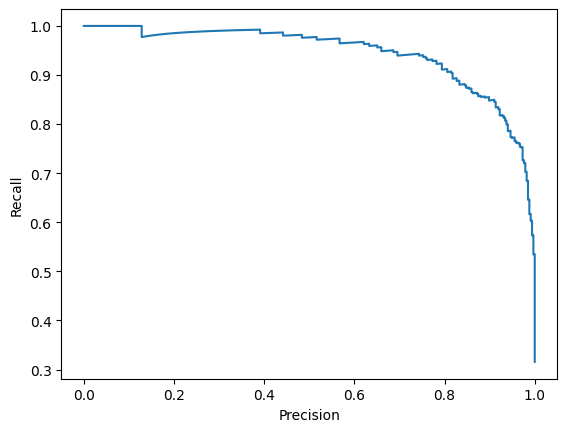

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(lbl_es, pred_es[0])

plt.plot(recall, precision)
plt.xlabel("Precision")
plt.ylabel("Recall")




In [38]:
# np.sum(ytrue, axis=1)
tce_labels.head(6) # TODO: Some objects have multiple labels or no labels - how to assess metrics?

disp_p  disp_e  disp_n  disp_j     TIC ID
astro_id                                           
1221           1       0       0       0  352764091
8397           0       0       0       0  387603144
2503           0       0       0       1  250340193
777            0       1       0       0  266676103
7282           1       0       0       0  295312916
5749           0       0       0       0  166697854

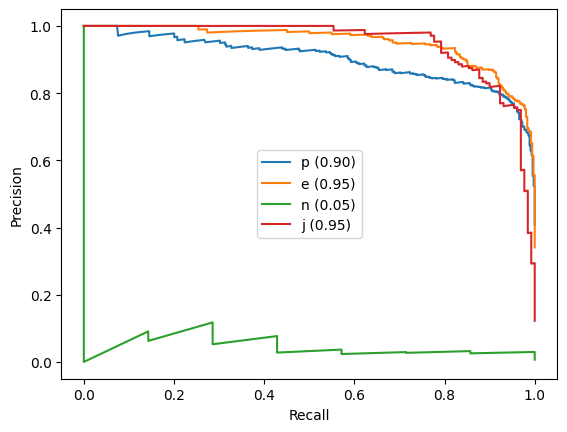

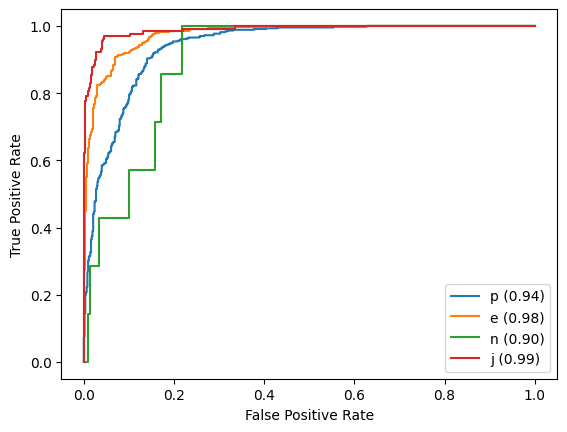

<Figure size 640x480 with 0 Axes>

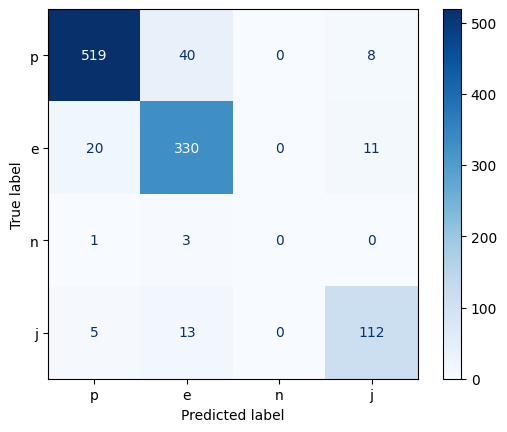

In [39]:
# Make PR curve with Scikit learn

from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay


# i = 0 # i is the ensemble idx out of 10

ytrue = []
ypred = []
astro_id_preds = []
tic_id_preds = []
for astro_id in tce_labels.index:
    try:
        ypred.append(np.max(np.array([ensemble_preds[i].loc[astro_id].values for i in range(nruns)]), axis=0)) # i is the ensemble idx out of 10
        ytrue.append(tce_labels.loc[astro_id].values[:-1])
        astro_id_preds.append(astro_id)
        tic_id_preds.append(tce_labels.loc[astro_id].values[-1])
        # ypred.append(ensemble_preds[i].loc[astro_id].values)
    except Exception as e:
        print("ERROR: No object.", e)
        continue

ytrue = np.array(ytrue).astype(bool)
ypred = np.array(ypred)

# PR curve
plt.figure()
for l, label in enumerate(labels):
    precision, recall, thresholds = precision_recall_curve(ytrue[:,l], ypred[:,l])
    auc_val = auc(recall, precision)
    plt.plot(recall, precision, label=f"{label.split('_')[-1]} ({auc_val:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

# ROC curve
plt.figure()
for l, label in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(ytrue[:,l], ypred[:,l])
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label.split('_')[-1]} ({auc_val:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# Confusion Matrix
plt.figure()
cm = confusion_matrix(ytrue.argmax(axis=1),ypred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label.split('_')[-1] for label in labels])
disp.plot(cmap=plt.cm.Blues)


disp_p
0.4086629001883239 1.0 4.0645532e-11
0.40904806786050896 1.0 1.2641322e-08
0.40943396226415096 1.0 2.2688015e-08
0.4098205854579792 1.0 3.7846643e-08
0.4102079395085066 1.0 6.3675486e-08
0.4105960264900662 1.0 8.1731656e-08
0.4109848484848485 1.0 2.9494936e-07
0.41137440758293836 1.0 5.640545e-07
0.4117647058823529 1.0 8.223573e-07
0.4121557454890788 1.0 8.322849e-07
0.41254752851711024 1.0 1.044329e-06
0.41294005708848713 1.0 1.1165397e-06
0.41333333333333333 1.0 1.6650116e-06
0.41372735938989513 1.0 2.3511868e-06
0.41412213740458015 1.0 2.7255305e-06
0.4145176695319962 1.0 6.3907005e-06
0.4149139579349904 1.0 7.1956265e-06
0.415311004784689 1.0 8.326875e-06
0.4157088122605364 1.0 8.812763e-06
0.4161073825503356 1.0 9.4065035e-06
0.4165067178502879 1.0 1.8259803e-05
0.4169068203650336 1.0 1.9015852e-05
0.4173076923076923 1.0 1.9820116e-05
0.4177093358999038 1.0 2.6534868e-05
0.41811175337186895 1.0 2.7409604e-05
0.4185149469623915 1.0 2.902537e-05
0.4189189189189189 1.0 2.94106

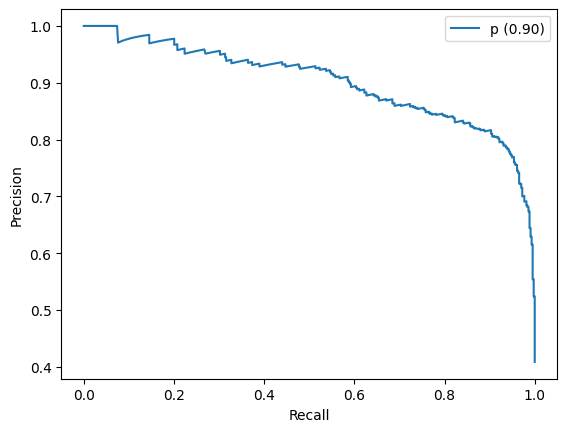

In [40]:
# PR curve
plt.figure()
for l, label in enumerate(labels):
    print(label)
    precision, recall, thresholds = precision_recall_curve(ytrue[:,l], ypred[:,l])
    auc_val = auc(recall, precision)
    plt.plot(recall, precision, label=f"{label.split('_')[-1]} ({auc_val:.2f})")
    if label == 'disp_p':
        break
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

for i in range(len(thresholds)):
    print(precision[i], recall[i], thresholds[i])

In [22]:
# Counts
tce_labels.sum()

disp_p             449
disp_e             355
disp_n               5
disp_j             149
TIC ID    277183691621
dtype: int64

AUC: 0.9437364756302304, max R: 1.0, max P: 1.0
100% recall at: 52%, threshold: 0.0054775886536190255


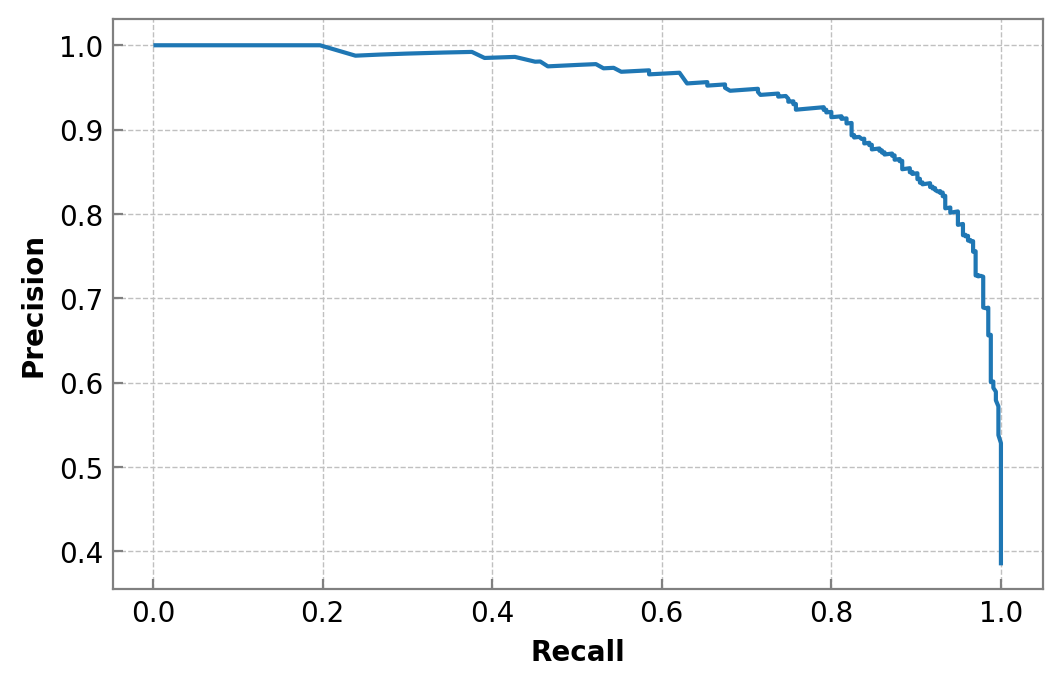

In [23]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

# plt.xlim((0.0, 1.0))
# plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)

In [23]:
i = 0
while ps[i] > 0.749:
    i += 1
print(f'74.9% precision at: {int(rs[i] * 100)}%, threshold: {ths[i]}')

74.9% precision at: 98%, threshold: 0.03699082088475919


In [24]:
# Get data
from astronet import models
from astronet.astro_cnn_model import input_ds

model_name = 'AstroCNNModelVetting'
config_name = 'base_new'
labels = ['p', 'e', 'n', 'j']
config = models.get_model_config(model_name, config_name)

ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=False,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=True,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_iter = iter(labels_ds)


2024-10-09 16:33:56.528917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


In [25]:
# Plot example light curves
ds = ds.cache()
def plot_ds_tce(ds, astro_id):
    for d in ds:
        if d[1] == astro_id:
            for k, v in d[0].items():
                if k.startswith('local_'):
                    continue
                if k.startswith('global_'):
                    continue
                if k.startswith('secondary_'):
                    continue
                if k.startswith('sample_'):
                    continue
                print(f'{k:25}: {v.numpy()}')
            global_view = np.array(d[0]['global_view'][0].numpy())
            local_view = np.array(d[0]['local_view'][0].numpy())
            secondary_view = np.array(d[0]['secondary_view'][0].numpy())
            fig, axes = plt.subplots(2, 3, figsize=(14, 5))
            axes[0, 0].plot(global_view, '.-')
            axes[0, 1].plot(local_view, '.-')
            axes[0, 2].plot(secondary_view, '.-')
            axes[1, 0].plot(d[0]['global_mask'][0].numpy(), '.-')
            axes[1, 1].plot(d[0]['global_view_0.3'][0].numpy(), '.-')
            axes[1, 2].plot(d[0]['global_view_5.0'][0].numpy(), '.-')
            
            # plt.show()
            # plt.close('all')
            plt.tight_layout()
            return fig, axes

In [26]:
pl.loc[573]

KeyError: 573

20 Astro ID: 768 || TIC ID: 265125525 || True label: [False  True False False] || Max predicted prob: [0.99 0.05 0.   0.  ]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         265125525
Name: 768, dtype: int64


2024-10-09 16:34:04.663940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


duration                 : [[-0.12222493]]
period                   : [[-0.1363467]]
tmag                     : [[1.3680524]]
transit_depth            : [[0.3450455]]
n_folds                  : [[0.5]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.24364565]]
star_rad_est             : [[-0.17152534]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:05.849775: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


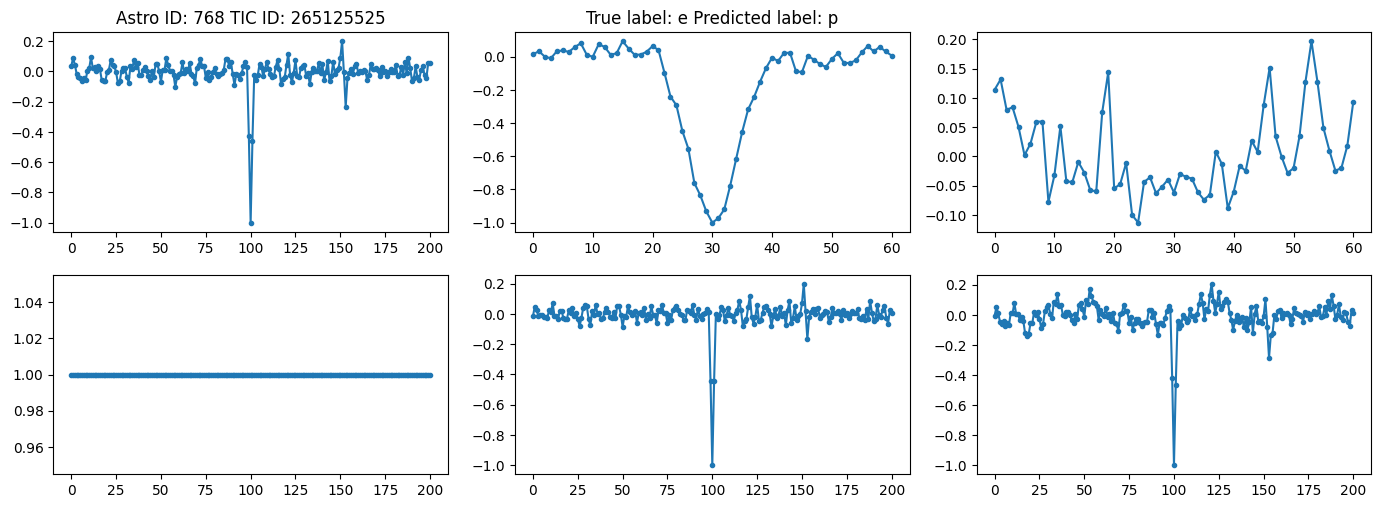

23 Astro ID: 1167 || TIC ID: 343484756 || True label: [False  True False False] || Max predicted prob: [0.07 0.39 0.05 0.75]
disp_p_pred            0
disp_e_pred            7
disp_n_pred            0
disp_j_pred            3
maxcount               7
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         343484756
Name: 1167, dtype: int64
duration                 : [[-0.16010024]]
period                   : [[-0.5469545]]
tmag                     : [[1.3942899]]
transit_depth            : [[0.30574816]]
n_folds                  : [[0.9795207]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[-0.22617592]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:07.185408: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


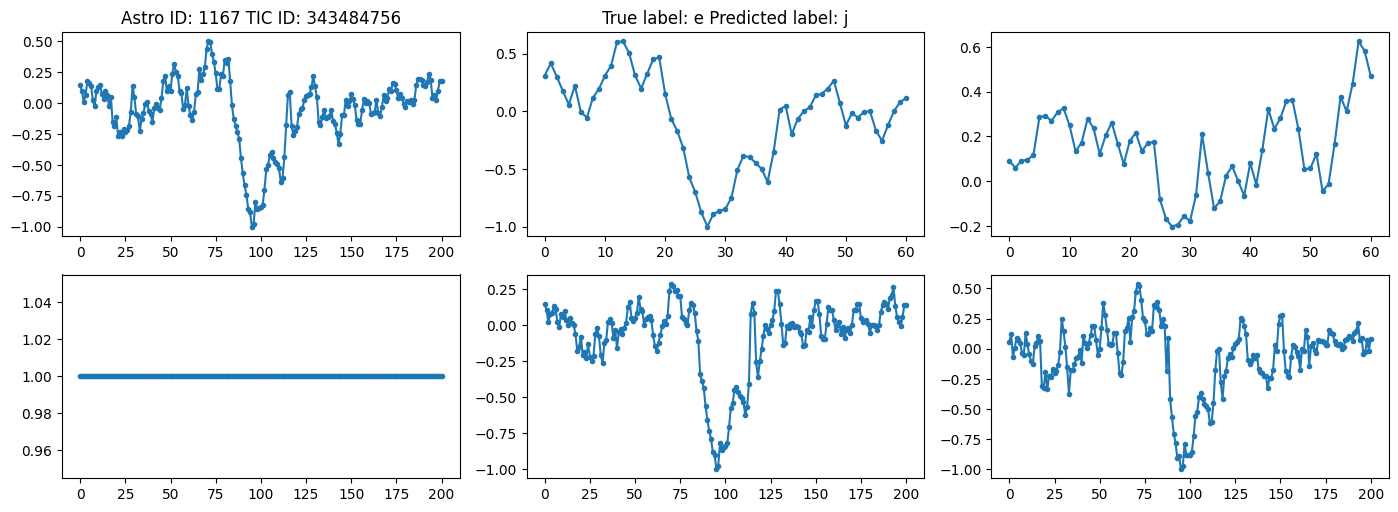

57 Astro ID: 364 || TIC ID: 81749728 || True label: [ True False False False] || Max predicted prob: [0.32 0.37 0.07 0.54]
disp_p_pred           0
disp_e_pred           9
disp_n_pred           0
disp_j_pred           1
maxcount              9
disp_p                1
disp_e                0
disp_n                0
disp_j                0
TIC ID         81749728
Name: 364, dtype: int64
duration                 : [[-0.14154041]]
period                   : [[-0.49689975]]
tmag                     : [[-0.19005433]]
transit_depth            : [[0.21031438]]
n_folds                  : [[0.7898918]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[0.12656096]]
star_rad_est             : [[-0.05850242]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:08.457465: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


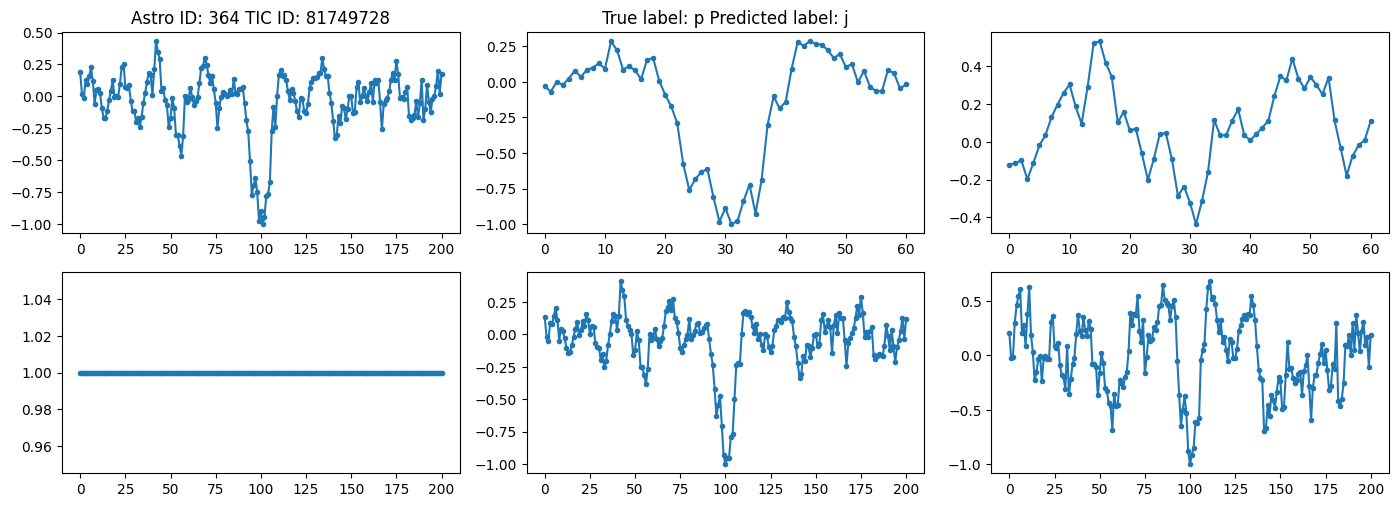

92 Astro ID: 3418 || TIC ID: 408628413 || True label: [ True False False False] || Max predicted prob: [0.27 0.55 0.05 0.61]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         408628413
Name: 3418, dtype: int64
duration                 : [[-0.14123914]]
period                   : [[-0.32337505]]
tmag                     : [[0.61084306]]
transit_depth            : [[0.3631905]]
n_folds                  : [[0.47712126]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:09.762473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


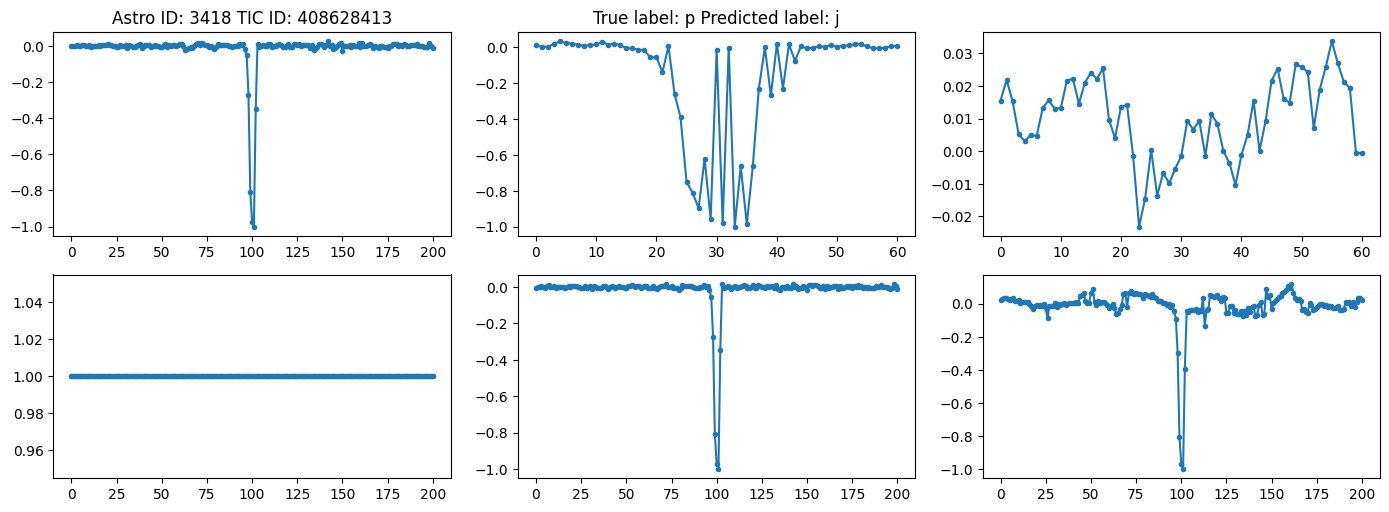

98 Astro ID: 1528 || TIC ID: 407922730 || True label: [False  True False False] || Max predicted prob: [0.84 0.36 0.04 0.25]
disp_p_pred            4
disp_e_pred            6
disp_n_pred            0
disp_j_pred            0
maxcount               6
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         407922730
Name: 1528, dtype: int64
duration                 : [[-0.23835781]]
period                   : [[-0.35651135]]
tmag                     : [[-0.42818597]]
transit_depth            : [[0.25326318]]
n_folds                  : [[0.650515]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[1.441394]]
star_rad_est             : [[0.14087619]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:11.285164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


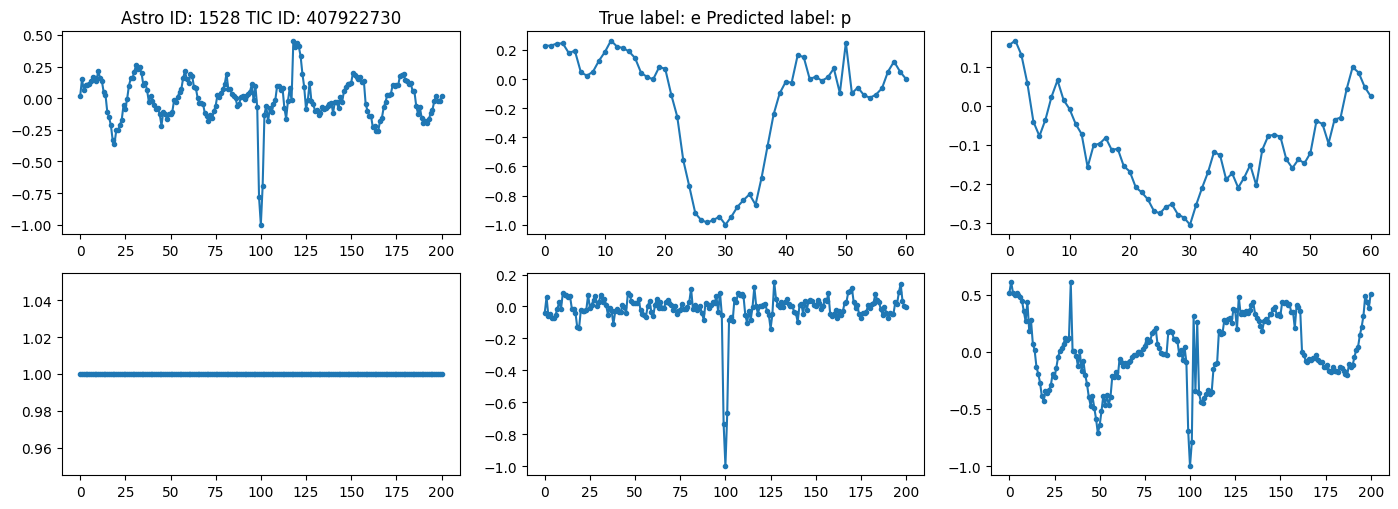

105 Astro ID: 27406 || TIC ID: 260927956 || True label: [False False False  True] || Max predicted prob: [0.   1.   0.   0.02]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 0
disp_n                 0
disp_j                 1
TIC ID         260927956
Name: 27406, dtype: int64
duration                 : [[1.2051578]]
period                   : [[-0.07063591]]
tmag                     : [[2.596353]]
transit_depth            : [[0.37182632]]
n_folds                  : [[0.573064]]
star_mass                : [[0.5140297]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.46895143]]
star_rad_est             : [[-0.21147624]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:12.557658: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


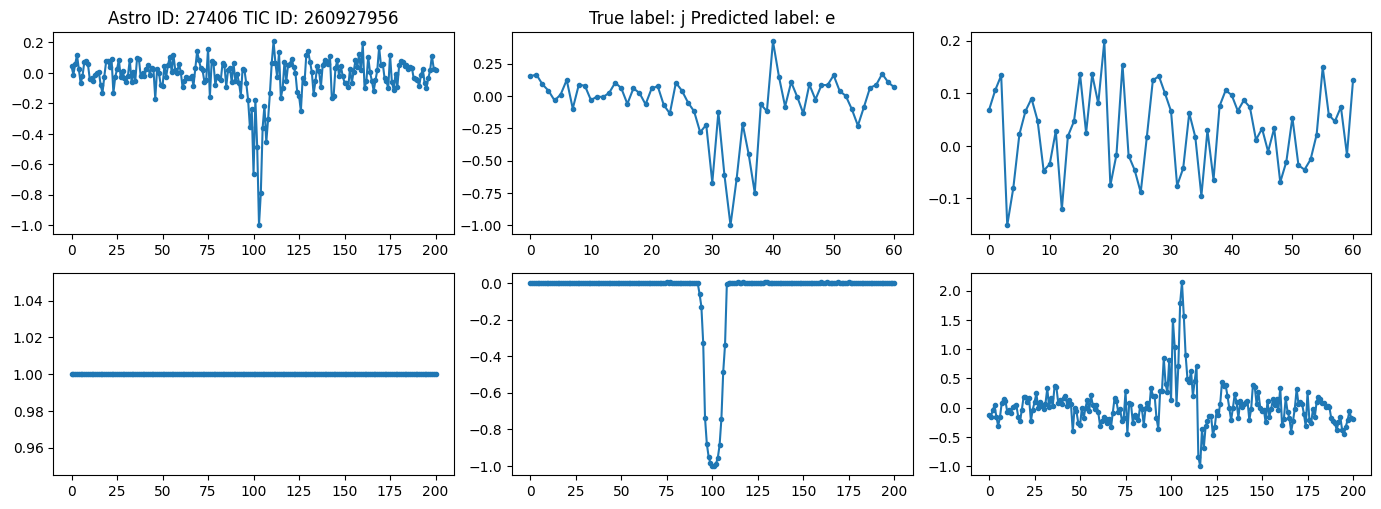

125 Astro ID: 7123 || TIC ID: 284900292 || True label: [ True False False False] || Max predicted prob: [0.48 0.   0.   0.97]
disp_p_pred            0
disp_e_pred            0
disp_n_pred            0
disp_j_pred           10
maxcount              10
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         284900292
Name: 7123, dtype: int64
duration                 : [[-0.06225436]]
period                   : [[1.1773975]]
tmag                     : [[1.9870327]]
transit_depth            : [[0.30572405]]
n_folds                  : [[0.7781513]]
star_mass                : [[-0.16623953]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.60297227]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:13.911871: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


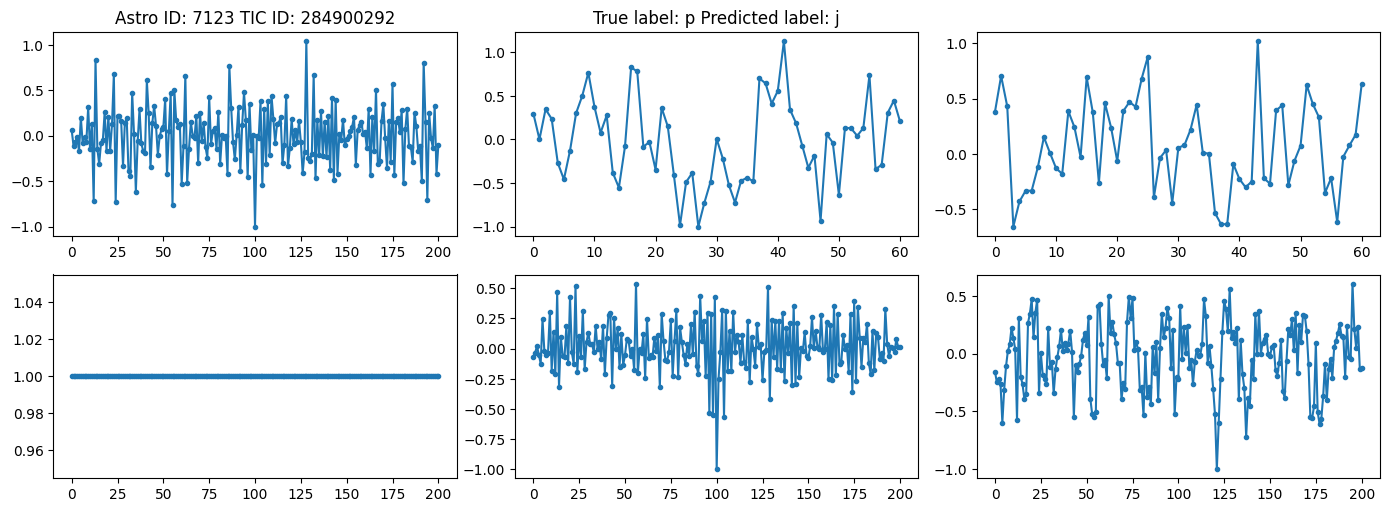

137 Astro ID: 2144 || TIC ID: 165625229 || True label: [ True False False False] || Max predicted prob: [0.5  0.7  0.02 0.13]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         165625229
Name: 2144, dtype: int64
duration                 : [[-0.187365]]
period                   : [[-0.20872873]]
tmag                     : [[0.35271224]]
transit_depth            : [[0.24681655]]
n_folds                  : [[0.62763625]]
star_mass                : [[0.40115857]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.5679515]]
star_rad_est             : [[-0.22617993]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:15.284151: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


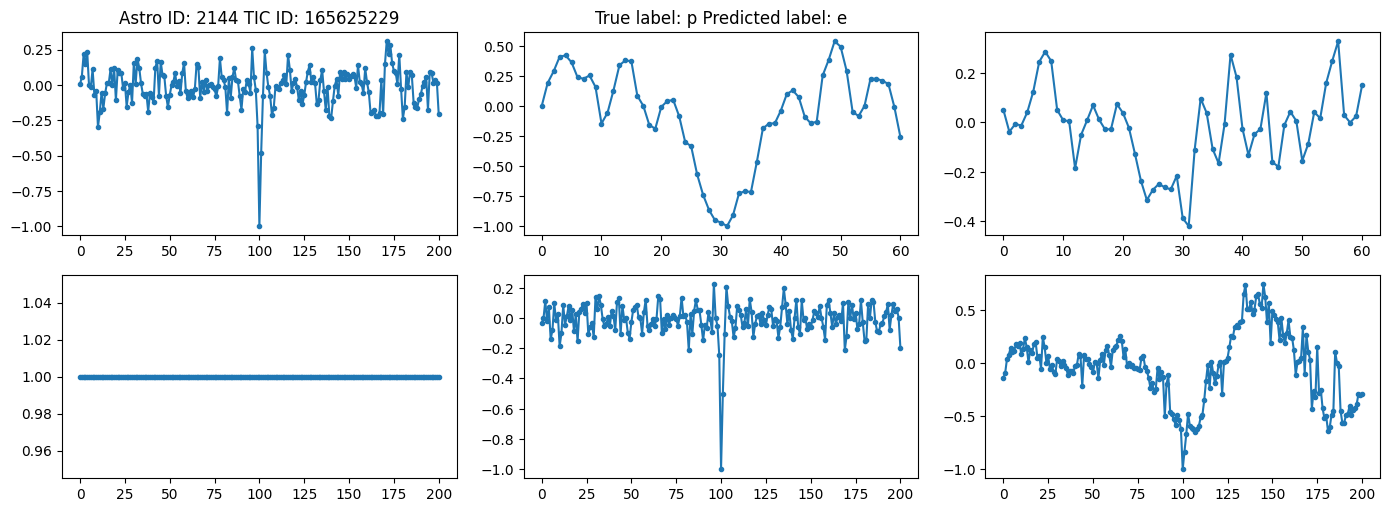

145 Astro ID: 2253 || TIC ID: 199949052 || True label: [ True  True False False] || Max predicted prob: [0.59 0.63 0.07 0.18]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 2
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         199949052
Name: 2253, dtype: int64
duration                 : [[-0.29171595]]
period                   : [[-0.5674725]]
tmag                     : [[0.8048504]]
transit_depth            : [[0.2562263]]
n_folds                  : [[0.9130374]]
star_mass                : [[0.5385669]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.5192494]]
star_rad_est             : [[-0.21718845]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:16.564953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


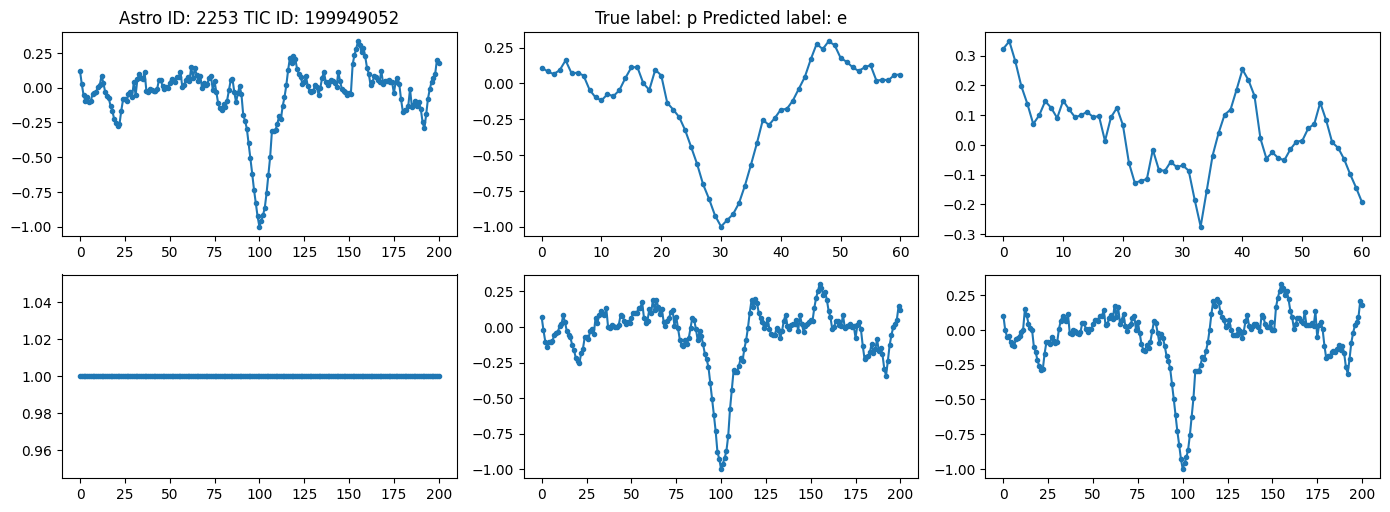

148 Astro ID: 1815 || TIC ID: 58142170 || True label: [False  True False False] || Max predicted prob: [0.69 0.47 0.   0.  ]
disp_p_pred           0
disp_e_pred          10
disp_n_pred           0
disp_j_pred           0
maxcount             10
disp_p                0
disp_e                1
disp_n                0
disp_j                0
TIC ID         58142170
Name: 1815, dtype: int64
duration                 : [[-0.05709379]]
period                   : [[-0.29366416]]
tmag                     : [[-0.54011637]]
transit_depth            : [[0.38584974]]
n_folds                  : [[0.422549]]
star_mass                : [[0.33000073]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.538073]]
star_rad_est             : [[-0.22085719]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:17.844198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


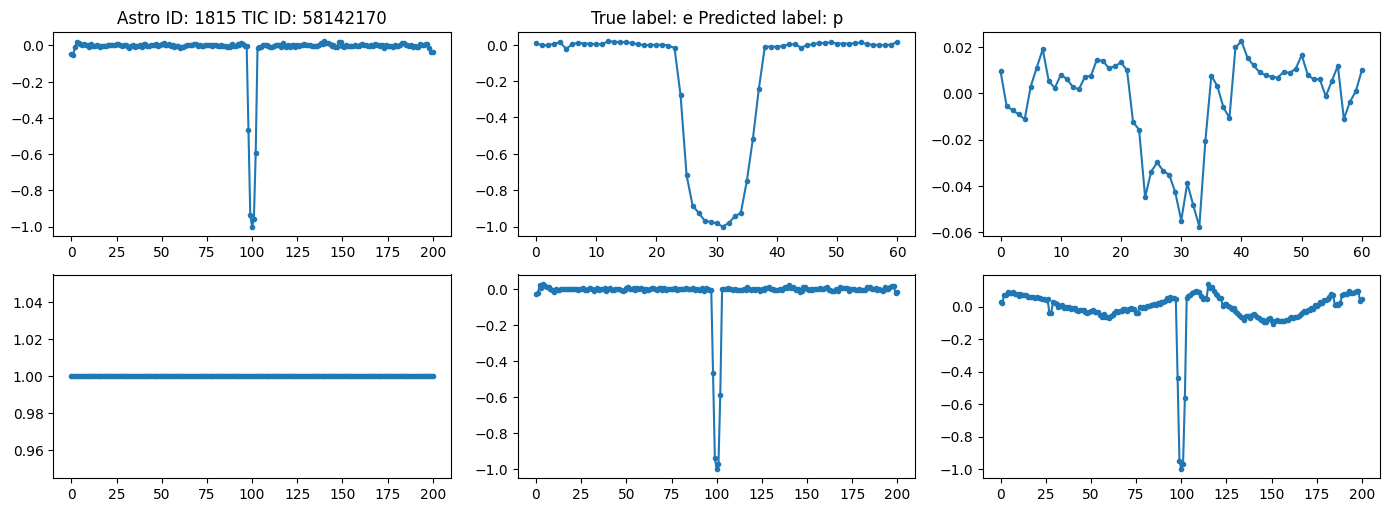

172 Astro ID: 963 || TIC ID: 300019694 || True label: [False  True False False] || Max predicted prob: [0.   0.02 0.   1.  ]
disp_p_pred            0
disp_e_pred            0
disp_n_pred            0
disp_j_pred           10
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         300019694
Name: 963, dtype: int64
duration                 : [[-0.12413479]]
period                   : [[-0.32004854]]
tmag                     : [[1.047968]]
transit_depth            : [[0.3665849]]
n_folds                  : [[0.60206]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.18723027]]
star_rad_est             : [[-0.15516277]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:19.374409: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


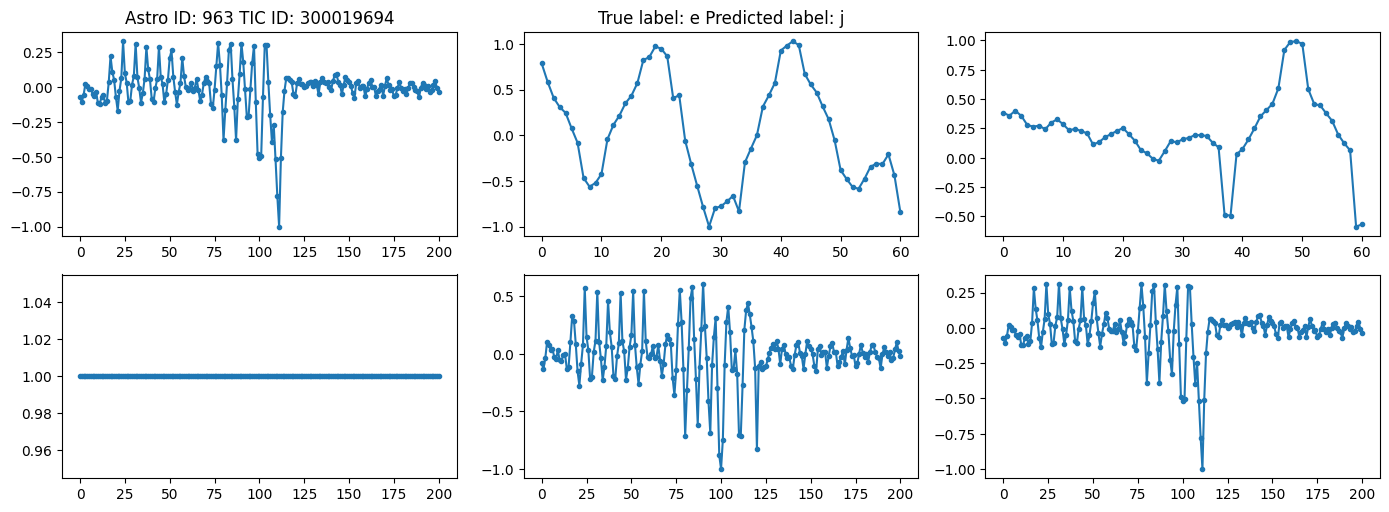

199 Astro ID: 1059 || TIC ID: 312083267 || True label: [False  True False False] || Max predicted prob: [0.89 0.31 0.   0.  ]
disp_p_pred            7
disp_e_pred            3
disp_n_pred            0
disp_j_pred            0
maxcount               7
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         312083267
Name: 1059, dtype: int64
duration                 : [[-0.21885383]]
period                   : [[-0.44734564]]
tmag                     : [[-0.51288754]]
transit_depth            : [[0.26818117]]
n_folds                  : [[0.69897]]
star_mass                : [[1.7715611]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.26331565]]
star_rad_est             : [[-0.17654528]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:21.089104: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


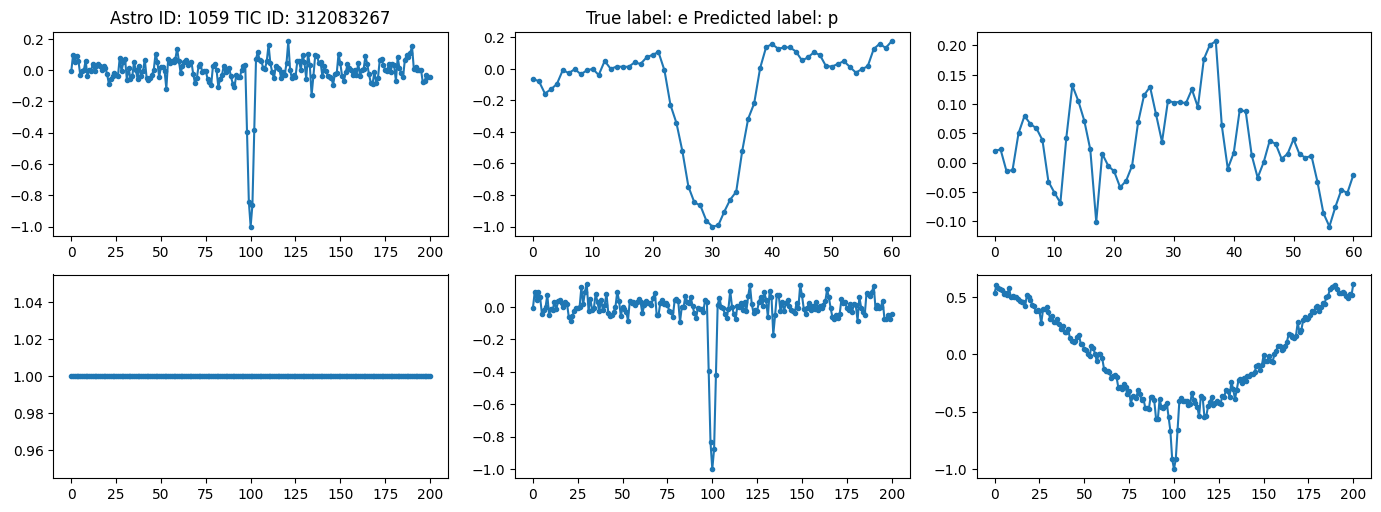

201 Astro ID: 1100 || TIC ID: 323144533 || True label: [False  True False False] || Max predicted prob: [0.92 0.59 0.01 0.01]
disp_p_pred            2
disp_e_pred            8
disp_n_pred            0
disp_j_pred            0
maxcount               8
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         323144533
Name: 1100, dtype: int64
duration                 : [[-0.15287073]]
period                   : [[-0.4520726]]
tmag                     : [[-0.10056054]]
transit_depth            : [[0.2203065]]
n_folds                  : [[0.91942453]]
star_mass                : [[0.87595344]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.46442193]]
star_rad_est             : [[-0.20765191]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:22.679251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


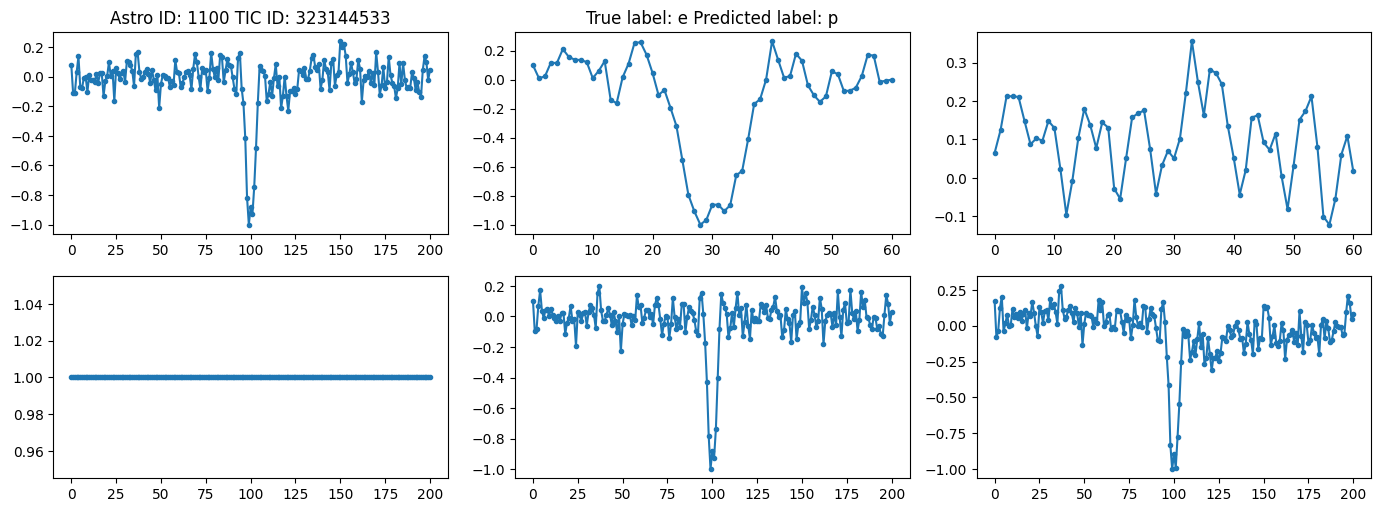

215 Astro ID: 2102 || TIC ID: 158490401 || True label: [False False  True False] || Max predicted prob: [0.34 0.89 0.   0.  ]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 0
disp_n                 1
disp_j                 0
TIC ID         158490401
Name: 2102, dtype: int64
duration                 : [[-0.18177924]]
period                   : [[-0.1333149]]
tmag                     : [[1.1399552]]
transit_depth            : [[0.38689035]]
n_folds                  : [[0.5]]
star_mass                : [[-0.25153083]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.6167521]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:24.064073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


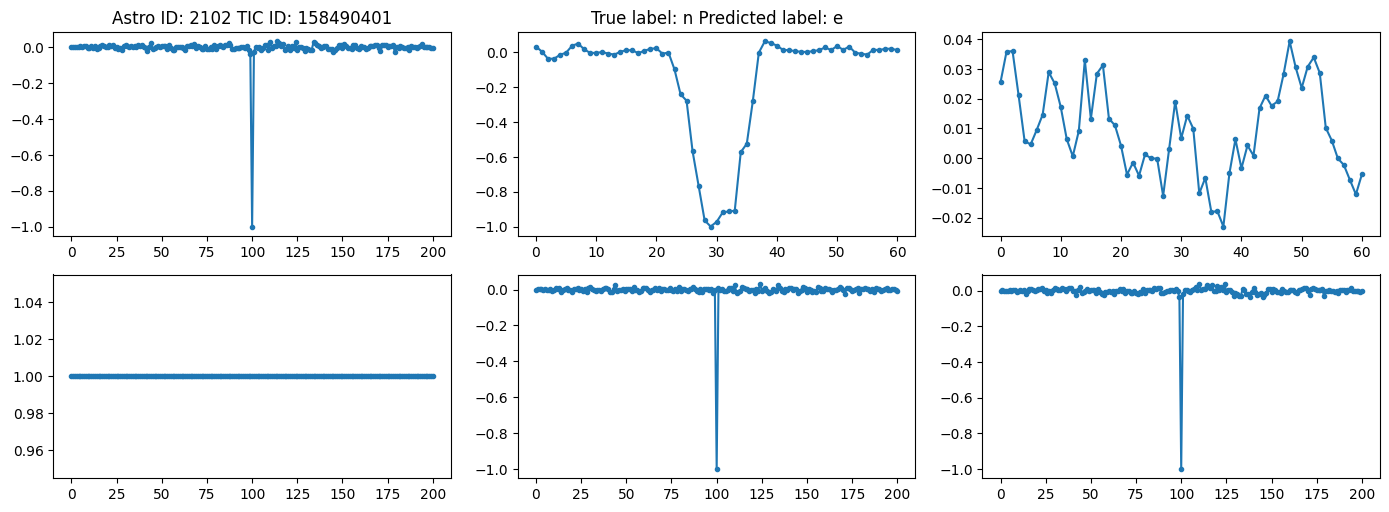

219 Astro ID: 3857 || TIC ID: 2020355003 || True label: [False False False  True] || Max predicted prob: [0.01 0.99 0.01 0.02]
disp_p_pred             0
disp_e_pred            10
disp_n_pred             0
disp_j_pred             0
maxcount               10
disp_p                  0
disp_e                  0
disp_n                  0
disp_j                  1
TIC ID         2020355003
Name: 3857, dtype: int64
duration                 : [[-0.20134051]]
period                   : [[-0.52178466]]
tmag                     : [[0.43927115]]
transit_depth            : [[0.36911568]]
n_folds                  : [[0.69897]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[-0.14085762]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:25.497127: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


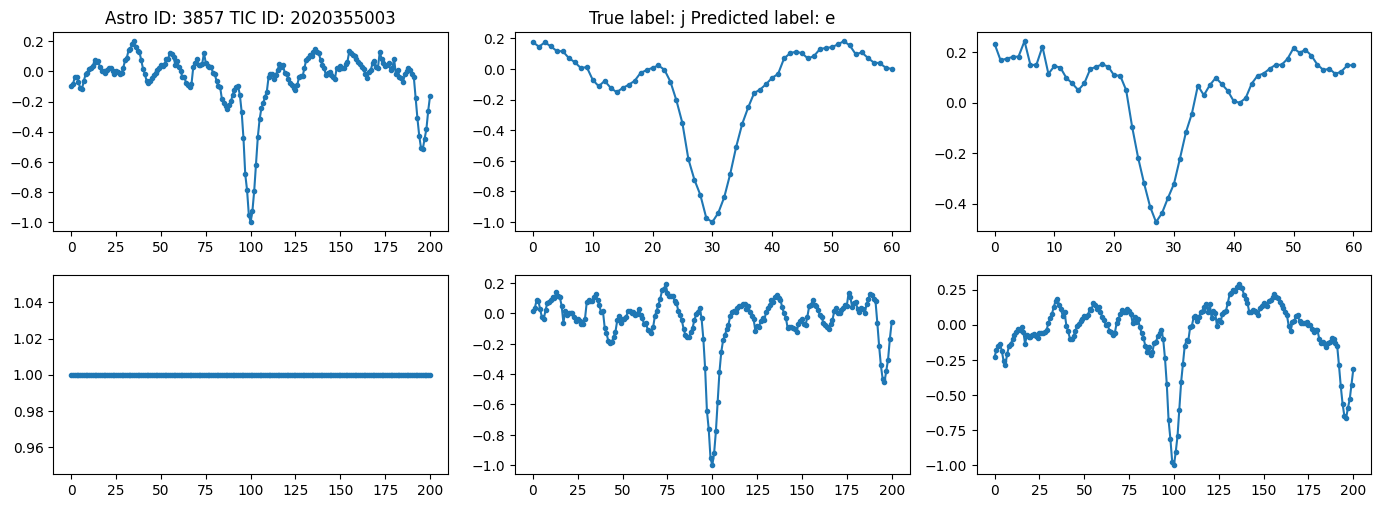

228 Astro ID: 3648 || TIC ID: 453319778 || True label: [False False False  True] || Max predicted prob: [0.91 0.09 0.05 0.7 ]
disp_p_pred            2
disp_e_pred            0
disp_n_pred            0
disp_j_pred            8
maxcount               8
disp_p                 0
disp_e                 0
disp_n                 0
disp_j                 1
TIC ID         453319778
Name: 3648, dtype: int64
duration                 : [[-0.20502591]]
period                   : [[-0.443855]]
tmag                     : [[-0.75849164]]
transit_depth            : [[0.24267583]]
n_folds                  : [[0.55697167]]
star_mass                : [[2.5628858]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.2230291]]
star_rad_est             : [[-0.16047236]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:26.902313: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


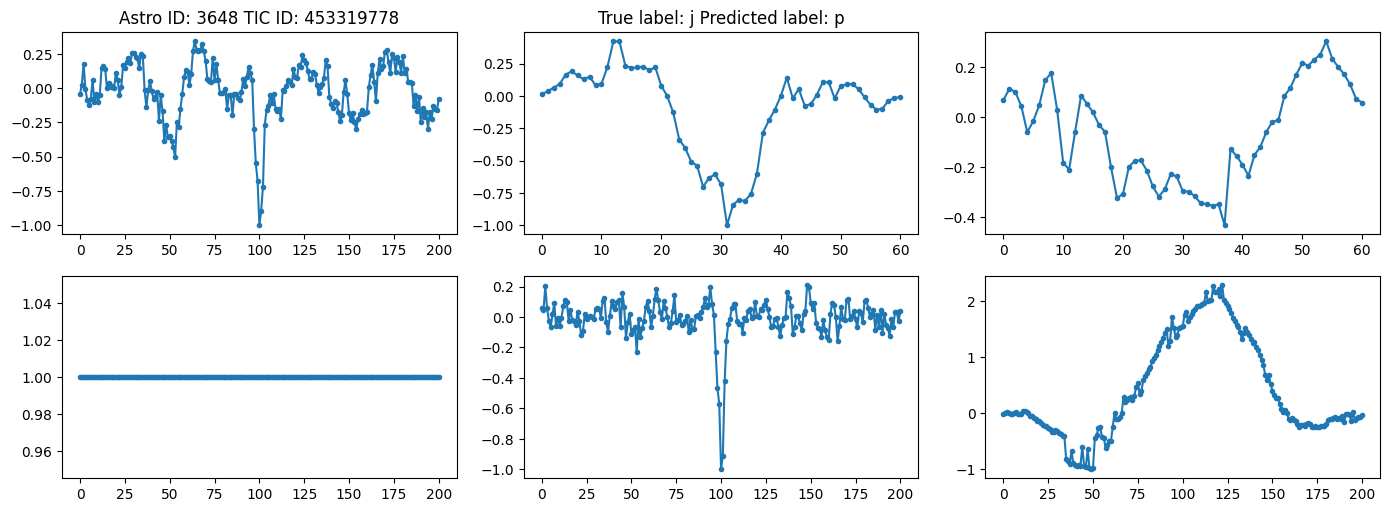

260 Astro ID: 3186 || TIC ID: 361047410 || True label: [False  True False False] || Max predicted prob: [0.95 0.2  0.   0.  ]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         361047410
Name: 3186, dtype: int64
duration                 : [[-0.193237]]
period                   : [[-0.4942538]]
tmag                     : [[0.13757111]]
transit_depth            : [[0.2558898]]
n_folds                  : [[0.80639195]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[1.4842123]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:28.457487: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


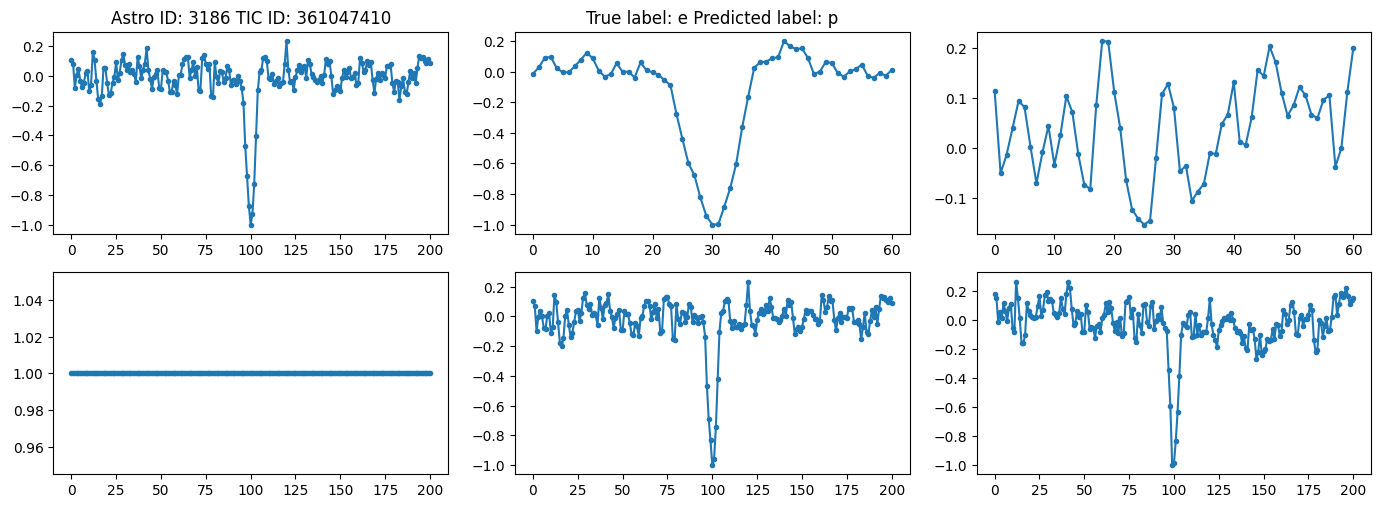

272 Astro ID: 5236 || TIC ID: 131419624 || True label: [ True False False False] || Max predicted prob: [0.51 0.04 0.03 0.85]
disp_p_pred            1
disp_e_pred            0
disp_n_pred            0
disp_j_pred            9
maxcount               9
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         131419624
Name: 5236, dtype: int64
duration                 : [[-0.16104995]]
period                   : [[-0.3280141]]
tmag                     : [[2.2580705]]
transit_depth            : [[0.31725845]]
n_folds                  : [[0.7841009]]
star_mass                : [[0.83301324]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.4867964]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:29.981511: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


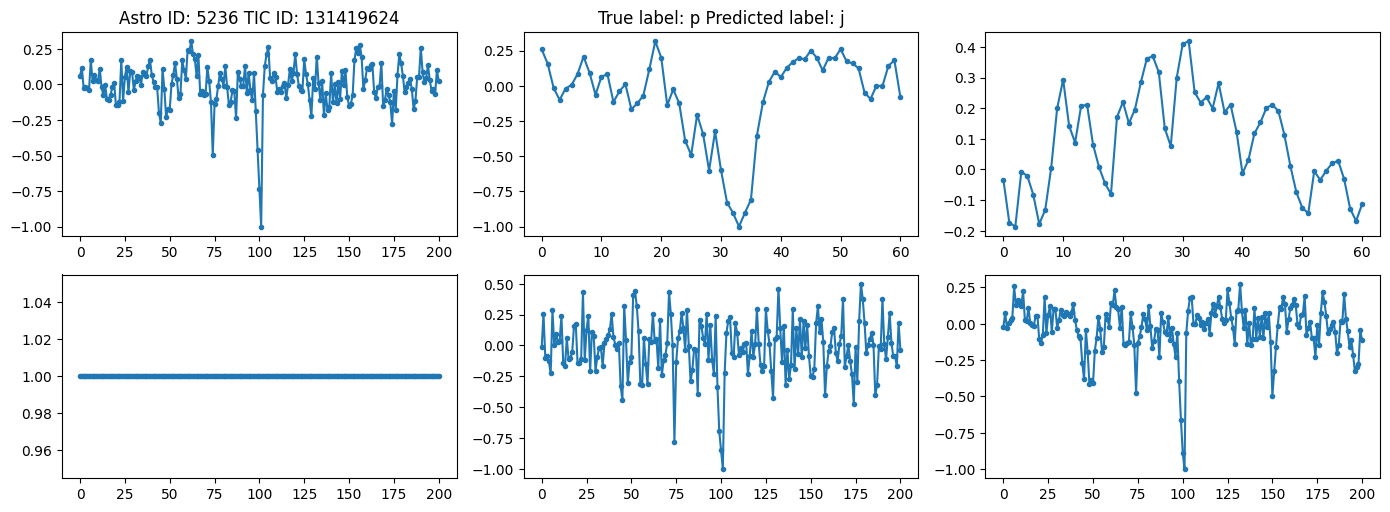

287 Astro ID: 3551 || TIC ID: 441793959 || True label: [False  True False False] || Max predicted prob: [0.99 0.03 0.   0.  ]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         441793959
Name: 3551, dtype: int64
duration                 : [[0.10144848]]
period                   : [[-0.29569668]]
tmag                     : [[0.9793519]]
transit_depth            : [[0.3461524]]
n_folds                  : [[0.88907564]]
star_mass                : [[0.5140297]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.39436844]]
star_rad_est             : [[-0.19660704]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:31.873487: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


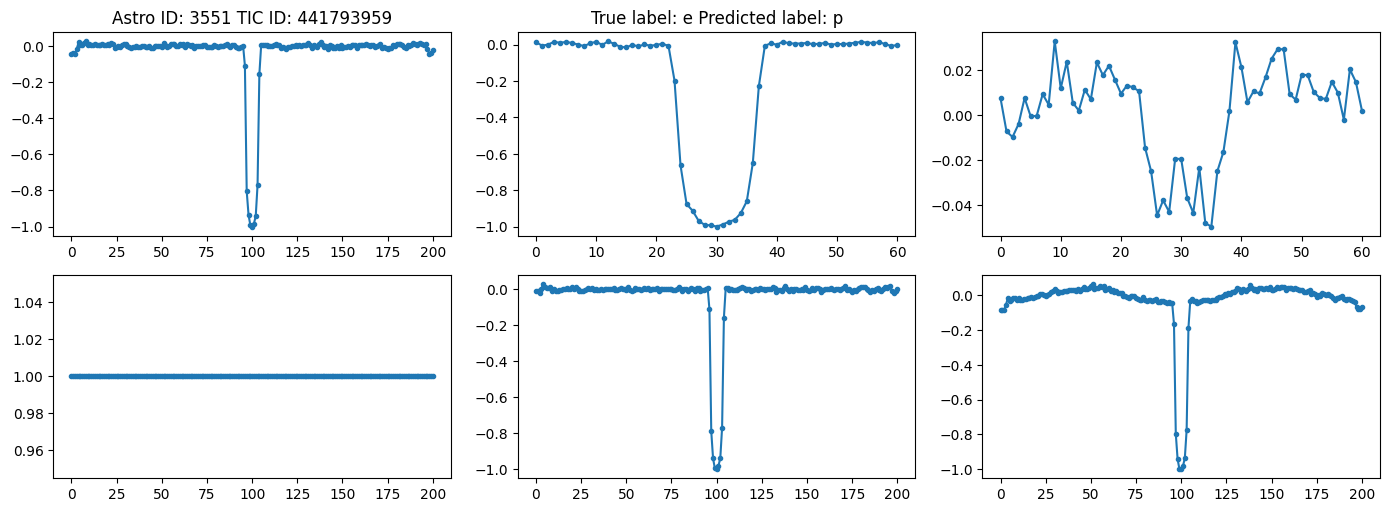

323 Astro ID: 1936 || TIC ID: 120315082 || True label: [False  True False False] || Max predicted prob: [0.77 0.48 0.01 0.  ]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         120315082
Name: 1936, dtype: int64
duration                 : [[-0.25939244]]
period                   : [[-0.48552758]]
tmag                     : [[0.40387183]]
transit_depth            : [[0.32228267]]
n_folds                  : [[0.650515]]
star_mass                : [[1.5077864]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.48903546]]
star_rad_est             : [[-0.21398431]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:32.911337: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


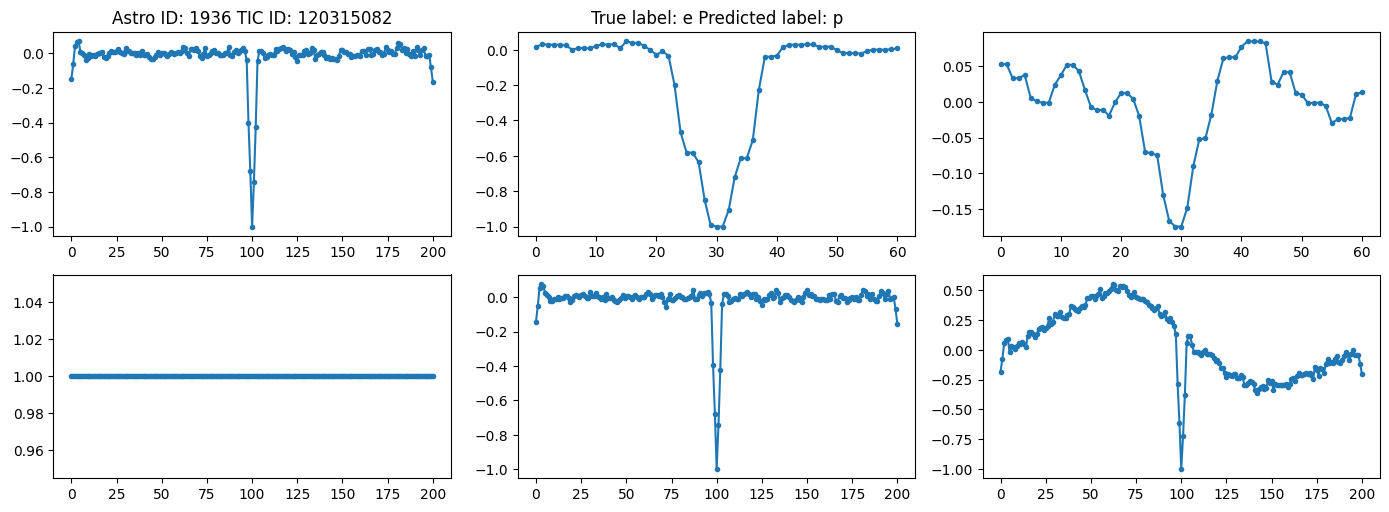

328 Astro ID: 98 || TIC ID: 122479370 || True label: [False  True False False] || Max predicted prob: [0.98 0.05 0.01 0.01]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         122479370
Name: 98, dtype: int64
duration                 : [[-0.18431783]]
period                   : [[-0.48180935]]
tmag                     : [[-0.00512743]]
transit_depth            : [[0.34703198]]
n_folds                  : [[0.6152245]]
star_mass                : [[1.1176448]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.43361616]]
star_rad_est             : [[-0.20651814]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:33.694790: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


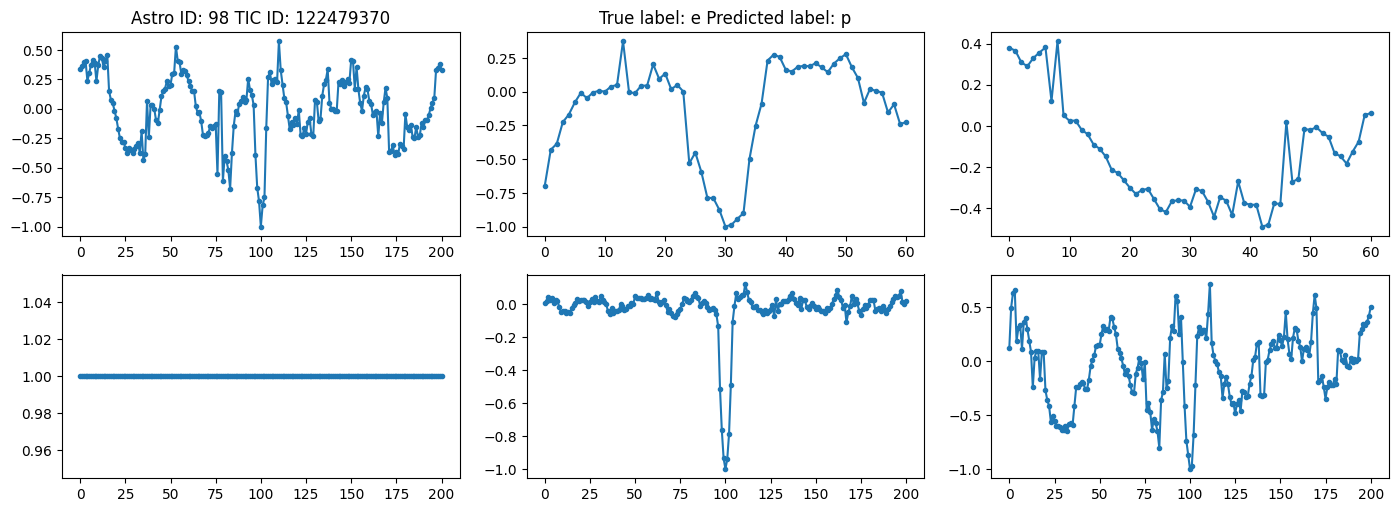

340 Astro ID: 26398 || TIC ID: 105450460 || True label: [False False False  True] || Max predicted prob: [0.   0.99 0.   0.02]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 0
disp_n                 0
disp_j                 1
TIC ID         105450460
Name: 26398, dtype: int64
duration                 : [[-0.1063282]]
period                   : [[-0.5542367]]
tmag                     : [[1.9226542]]
transit_depth            : [[0.3753881]]
n_folds                  : [[0.96975964]]
star_mass                : [[0.6821096]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.53362703]]
star_rad_est             : [[-0.21901156]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:34.490209: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


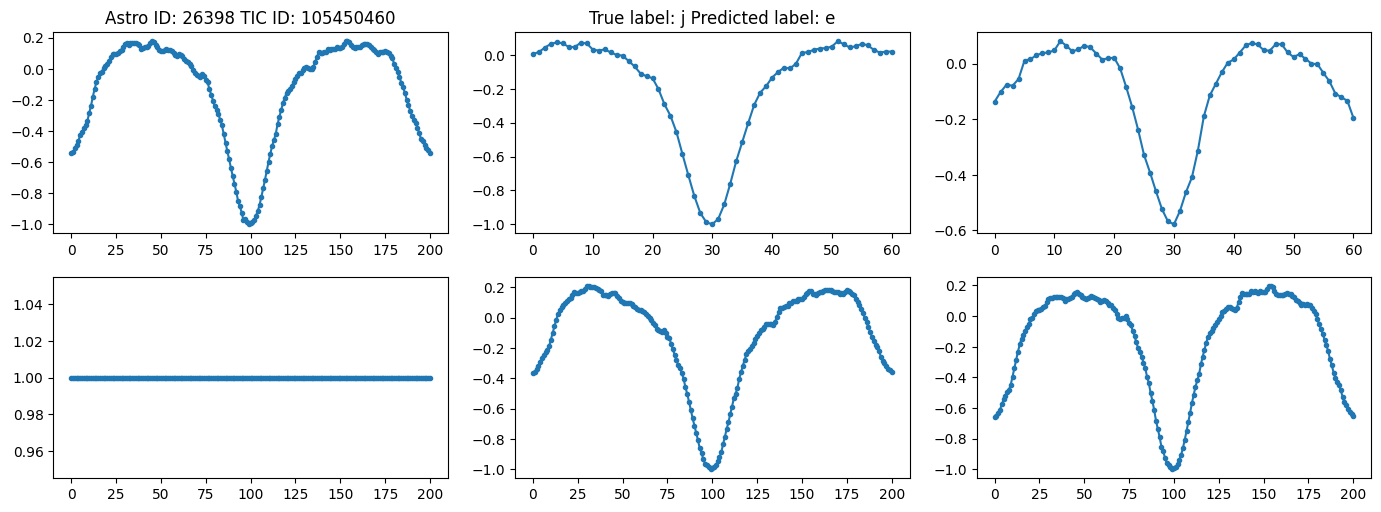

360 Astro ID: 8140 || TIC ID: 366755319 || True label: [ True False False False] || Max predicted prob: [0.64 0.68 0.01 0.01]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         366755319
Name: 8140, dtype: int64
duration                 : [[-0.15012427]]
period                   : [[-0.06028578]]
tmag                     : [[1.7226012]]
transit_depth            : [[0.33651388]]
n_folds                  : [[0.5]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.55773914]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:35.312254: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


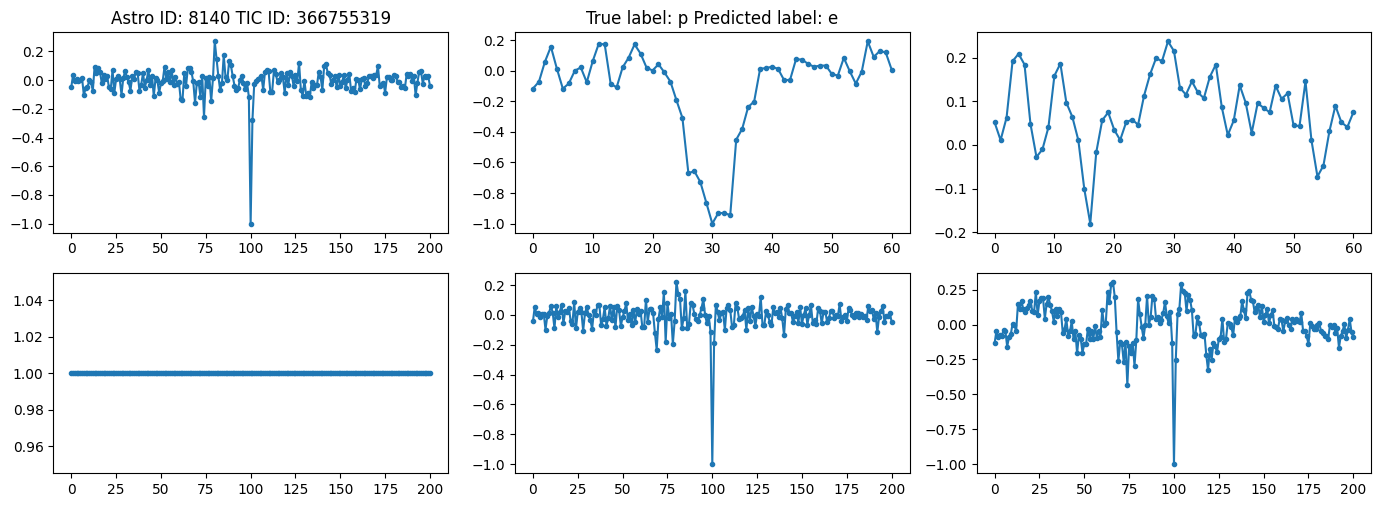

375 Astro ID: 1745 || TIC ID: 29833696 || True label: [ True  True False False] || Max predicted prob: [0.61 0.09 0.05 0.8 ]
disp_p_pred           3
disp_e_pred           0
disp_n_pred           0
disp_j_pred           7
maxcount              7
disp_p                1
disp_e                3
disp_n                0
disp_j                0
TIC ID         29833696
Name: 1745, dtype: int64
duration                 : [[-0.16623405]]
period                   : [[-0.26682174]]
tmag                     : [[0.68388414]]
transit_depth            : [[0.23209111]]
n_folds                  : [[0.8926649]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[0.4023261]]
star_rad_est             : [[-0.05989734]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:36.155811: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


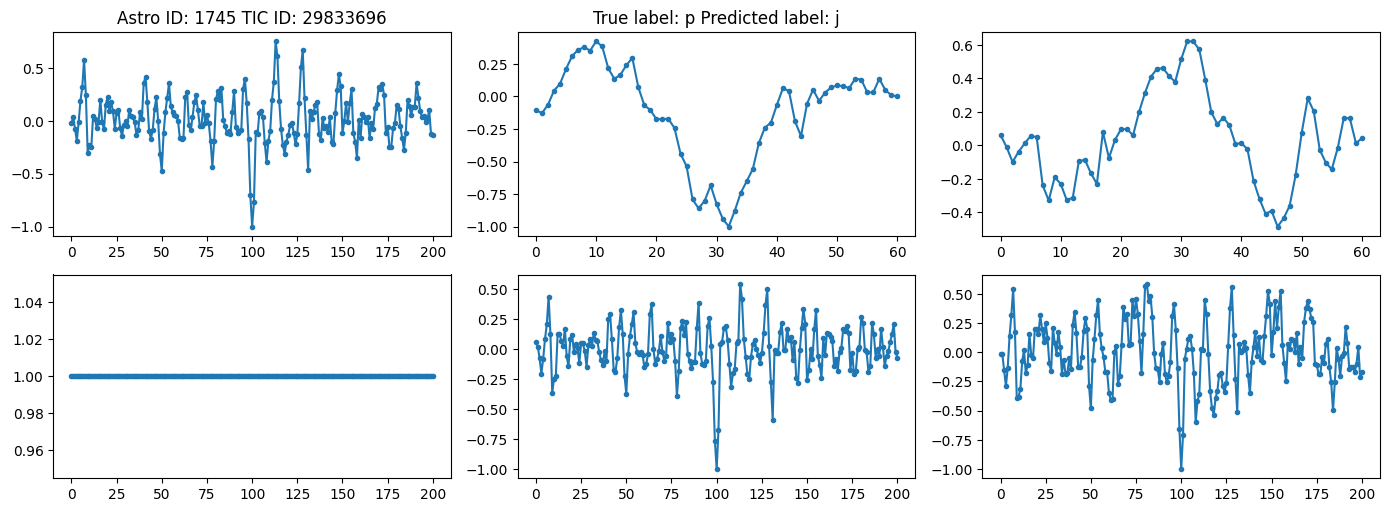

391 Astro ID: 27057 || TIC ID: 206482593 || True label: [False False False  True] || Max predicted prob: [0.82 0.   0.   0.62]
disp_p_pred            8
disp_e_pred            0
disp_n_pred            0
disp_j_pred            2
maxcount               8
disp_p                 0
disp_e                 0
disp_n                 0
disp_j                 1
TIC ID         206482593
Name: 27057, dtype: int64
duration                 : [[0.7834962]]
period                   : [[-0.05176071]]
tmag                     : [[0.5993133]]
transit_depth            : [[0.27766198]]
n_folds                  : [[0.52069634]]
star_mass                : [[0.32018584]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.43661803]]
star_rad_est             : [[-0.20859455]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:37.027650: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


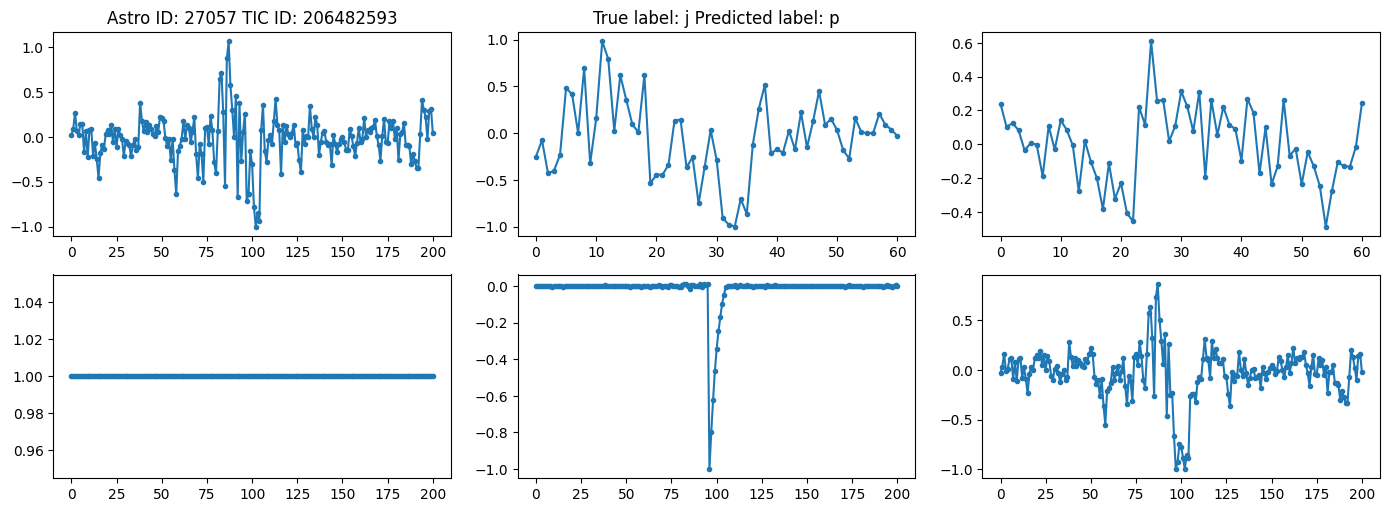

392 Astro ID: 2222 || TIC ID: 190223929 || True label: [False False False  True] || Max predicted prob: [0.28 0.87 0.01 0.01]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 0
disp_n                 0
disp_j                 1
TIC ID         190223929
Name: 2222, dtype: int64
duration                 : [[-0.23761977]]
period                   : [[-0.3849937]]
tmag                     : [[1.182209]]
transit_depth            : [[0.30274594]]
n_folds                  : [[0.5]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[-0.2058662]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:38.181892: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


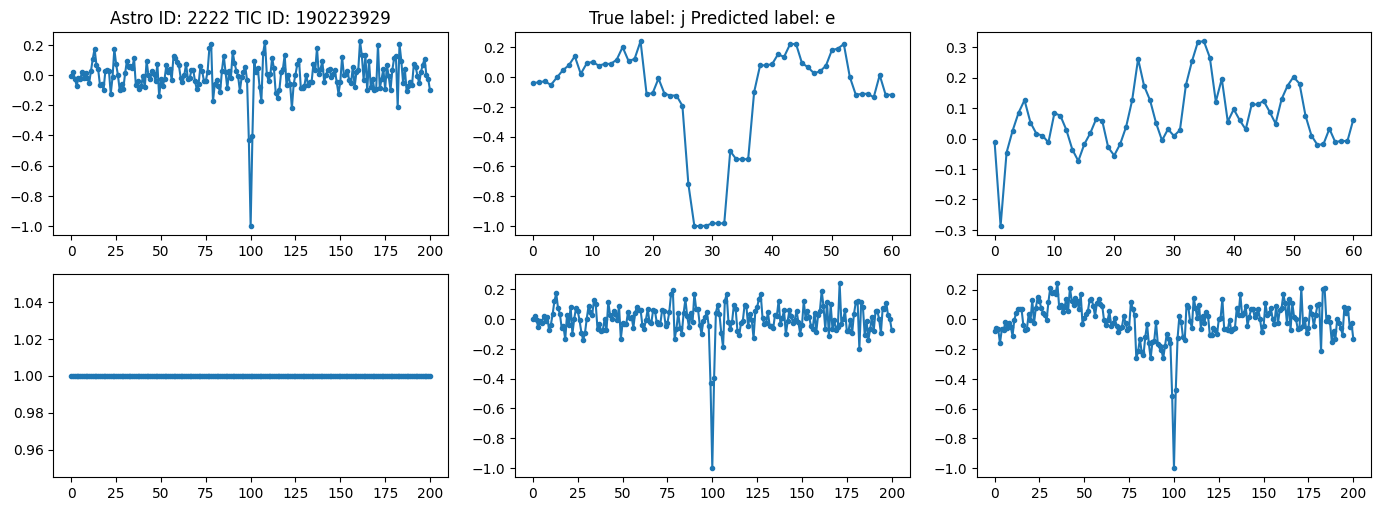

395 Astro ID: 3196 || TIC ID: 364843934 || True label: [False  True False False] || Max predicted prob: [0.01 0.54 0.02 0.8 ]
disp_p_pred            0
disp_e_pred            8
disp_n_pred            0
disp_j_pred            2
maxcount               8
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         364843934
Name: 3196, dtype: int64
duration                 : [[-0.16116524]]
period                   : [[-0.5273547]]
tmag                     : [[0.9564172]]
transit_depth            : [[0.253113]]
n_folds                  : [[0.731199]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[10.136308]]
star_rad_est             : [[1.2692398]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:39.066371: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


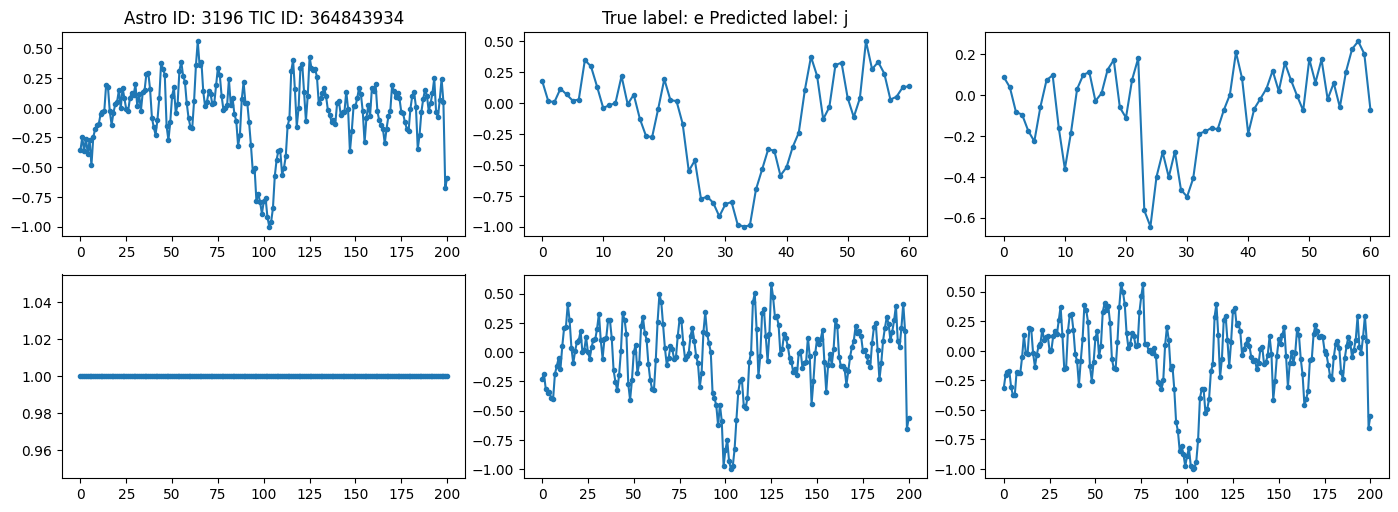

431 Astro ID: 2525 || TIC ID: 255994336 || True label: [False  True False False] || Max predicted prob: [0.98 0.18 0.   0.  ]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         255994336
Name: 2525, dtype: int64
duration                 : [[0.08814931]]
period                   : [[0.49805117]]
tmag                     : [[-0.0929945]]
transit_depth            : [[0.3231746]]
n_folds                  : [[0.58804566]]
star_mass                : [[0.88699514]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.3504464]]
star_rad_est             : [[-0.1862452]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:39.969521: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


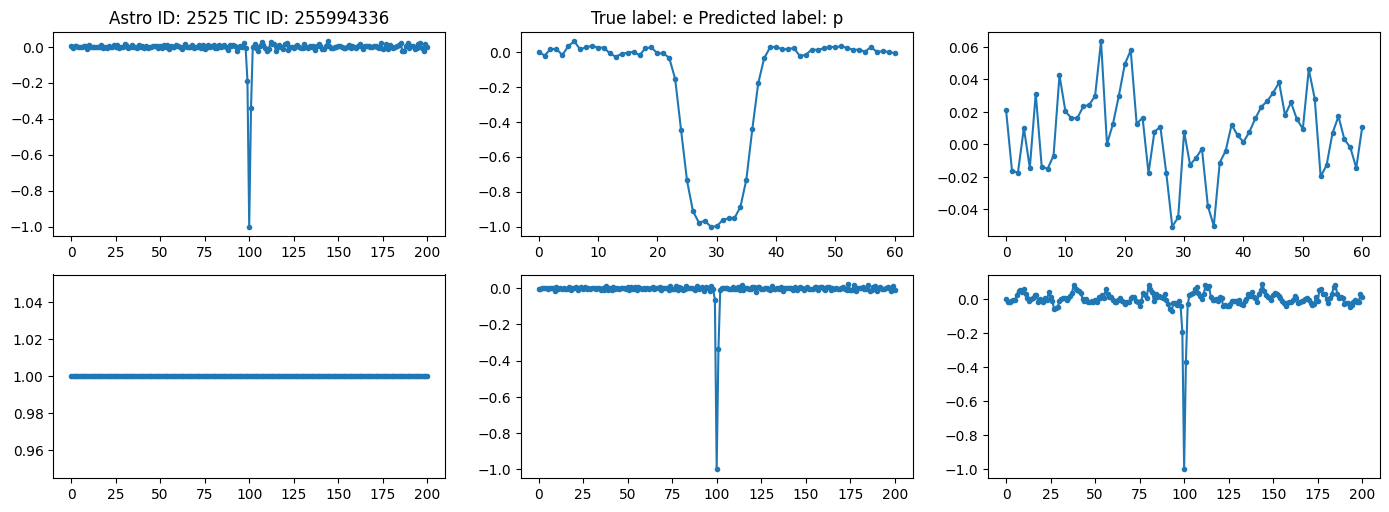

440 Astro ID: 5748 || TIC ID: 166648874 || True label: [ True False False False] || Max predicted prob: [0.02 0.04 0.01 0.98]
disp_p_pred            0
disp_e_pred            0
disp_n_pred            0
disp_j_pred           10
maxcount              10
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         166648874
Name: 5748, dtype: int64
duration                 : [[-0.23041691]]
period                   : [[-0.04591387]]
tmag                     : [[2.1281295]]
transit_depth            : [[0.3229103]]
n_folds                  : [[0.5]]
star_mass                : [[-0.4266553]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.6243734]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:40.881609: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


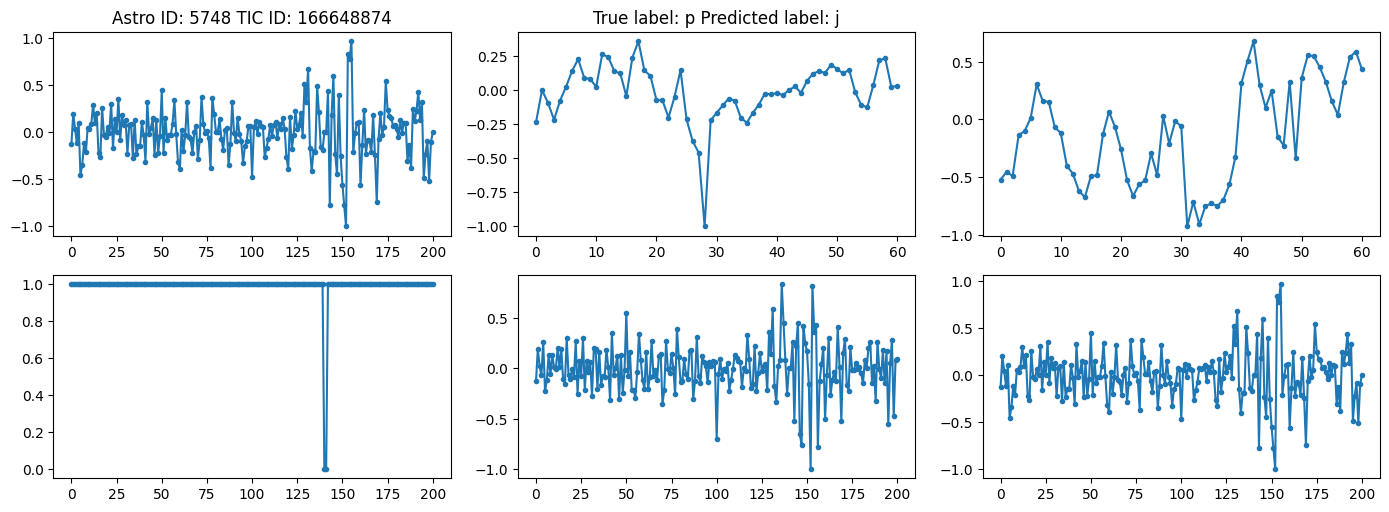

451 Astro ID: 1845 || TIC ID: 70323438 || True label: [False  True False False] || Max predicted prob: [0.03 0.09 0.03 0.92]
disp_p_pred           0
disp_e_pred           0
disp_n_pred           0
disp_j_pred          10
maxcount             10
disp_p                0
disp_e                1
disp_n                0
disp_j                0
TIC ID         70323438
Name: 1845, dtype: int64
duration                 : [[-0.14750753]]
period                   : [[-0.53219205]]
tmag                     : [[0.47635245]]
transit_depth            : [[0.24613622]]
n_folds                  : [[0.7385606]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[0.36328927]]
star_rad_est             : [[-0.05176819]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:41.749736: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


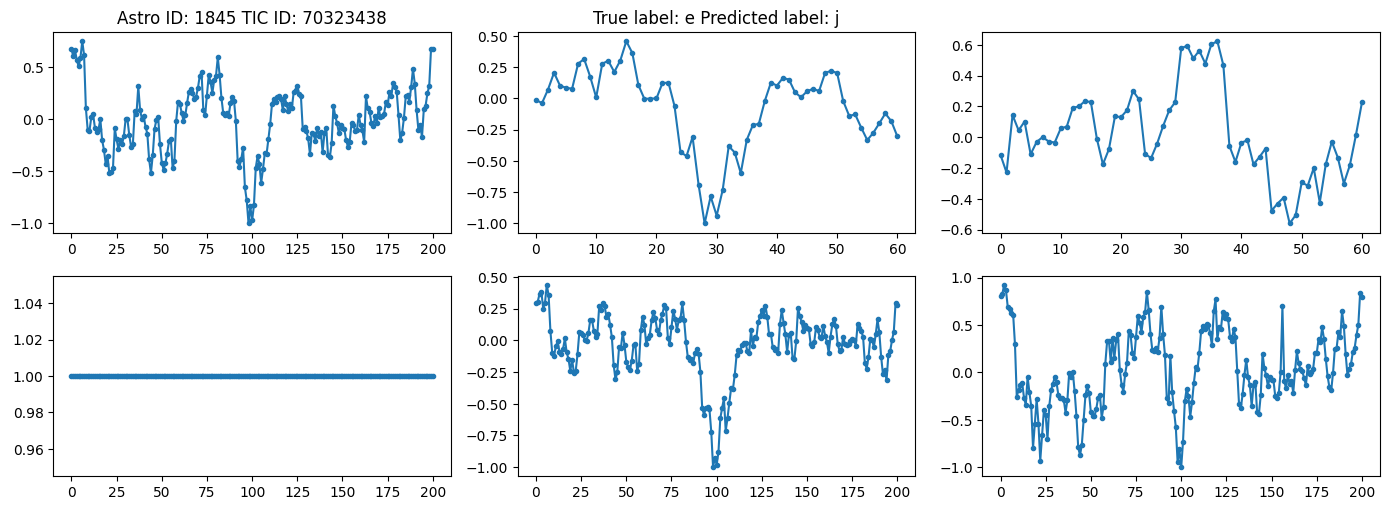

467 Astro ID: 3041 || TIC ID: 333745188 || True label: [False False False  True] || Max predicted prob: [0.28 0.91 0.04 0.41]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 0
disp_n                 0
disp_j                 1
TIC ID         333745188
Name: 3041, dtype: int64
duration                 : [[-0.24440342]]
period                   : [[-0.4870191]]
tmag                     : [[1.1440055]]
transit_depth            : [[0.27228388]]
n_folds                  : [[0.60206]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[3.848821]]
star_rad_est             : [[0.8565875]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:42.643028: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


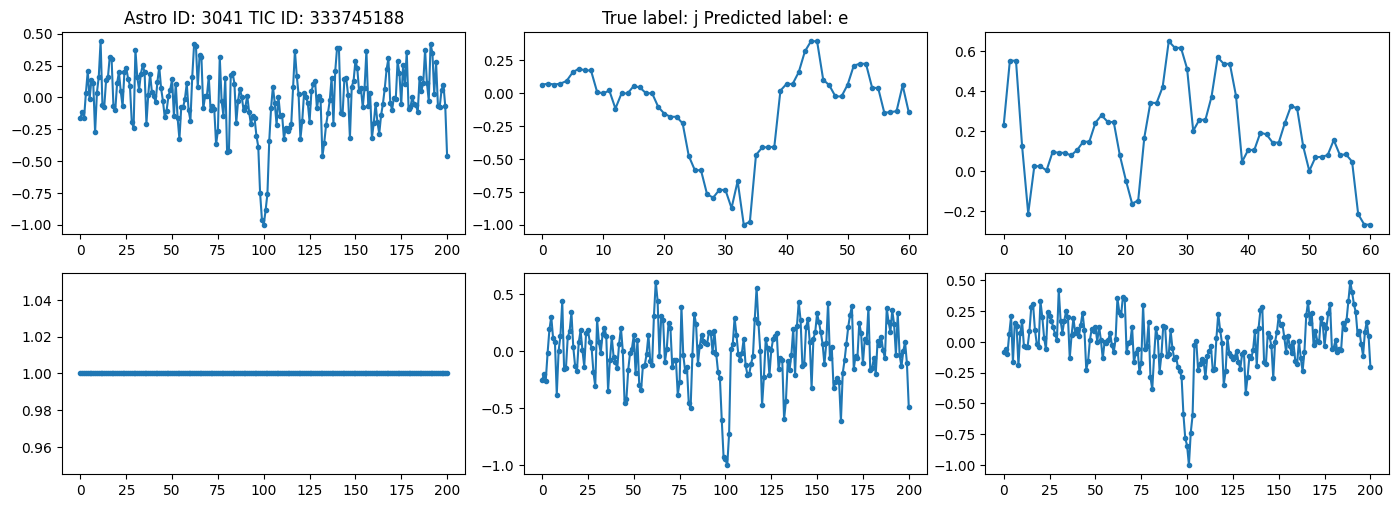

488 Astro ID: 1392 || TIC ID: 383390727 || True label: [False False  True False] || Max predicted prob: [0.59 0.61 0.06 0.15]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 0
disp_n                 1
disp_j                 0
TIC ID         383390727
Name: 1392, dtype: int64
duration                 : [[-0.19683138]]
period                   : [[-0.55850077]]
tmag                     : [[1.2238401]]
transit_depth            : [[0.22298808]]
n_folds                  : [[1.0021607]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.3551596]]
star_rad_est             : [[-0.18924224]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:43.817091: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


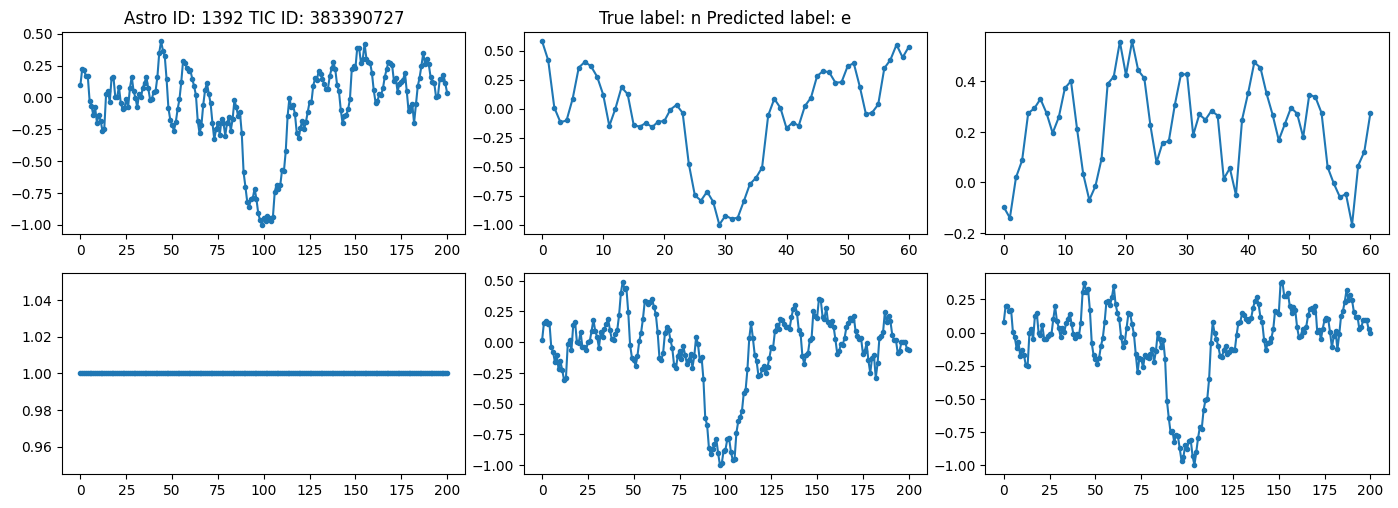

495 Astro ID: 549 || TIC ID: 180416826 || True label: [False  True False False] || Max predicted prob: [0.98 0.25 0.   0.  ]
disp_p_pred            9
disp_e_pred            1
disp_n_pred            0
disp_j_pred            0
maxcount               9
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         180416826
Name: 549, dtype: int64
duration                 : [[-0.238595]]
period                   : [[-0.51004416]]
tmag                     : [[0.0599179]]
transit_depth            : [[0.29061058]]
n_folds                  : [[0.849485]]
star_mass                : [[1.1765342]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.5103643]]
star_rad_est             : [[-0.21648222]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:45.186709: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


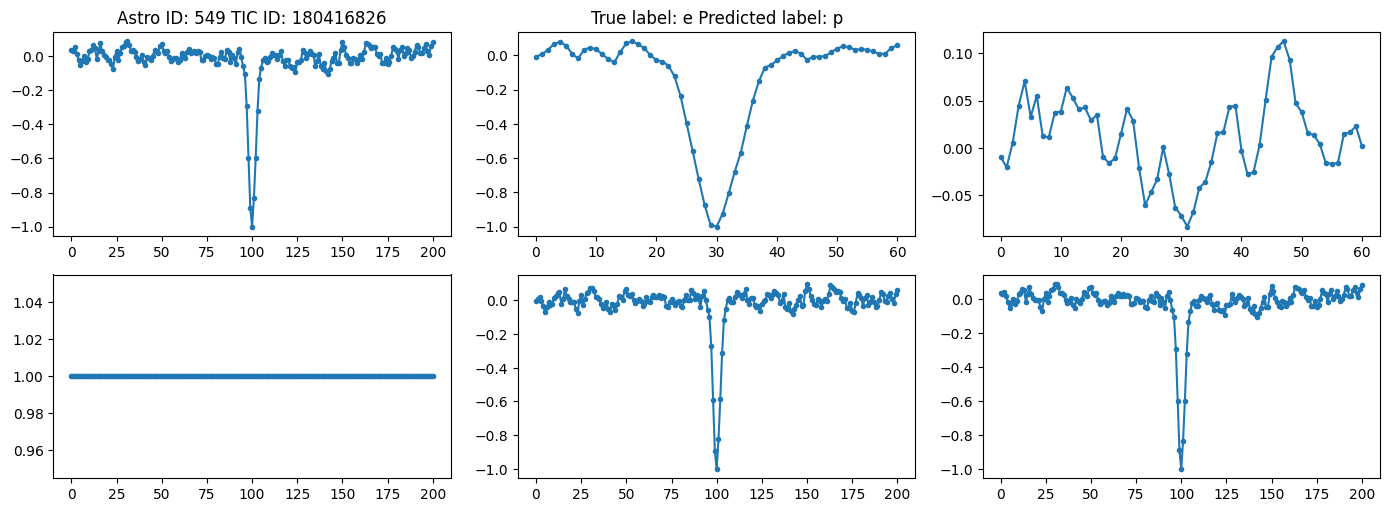

503 Astro ID: 5481 || TIC ID: 148479278 || True label: [ True False False False] || Max predicted prob: [0.08 0.   0.01 0.99]
disp_p_pred            0
disp_e_pred            0
disp_n_pred            0
disp_j_pred           10
maxcount              10
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         148479278
Name: 5481, dtype: int64
duration                 : [[-0.16075441]]
period                   : [[-0.5697494]]
tmag                     : [[0.10771885]]
transit_depth            : [[0.18085416]]
n_folds                  : [[1.0021607]]
star_mass                : [[1.1274596]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.5147636]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:46.079140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


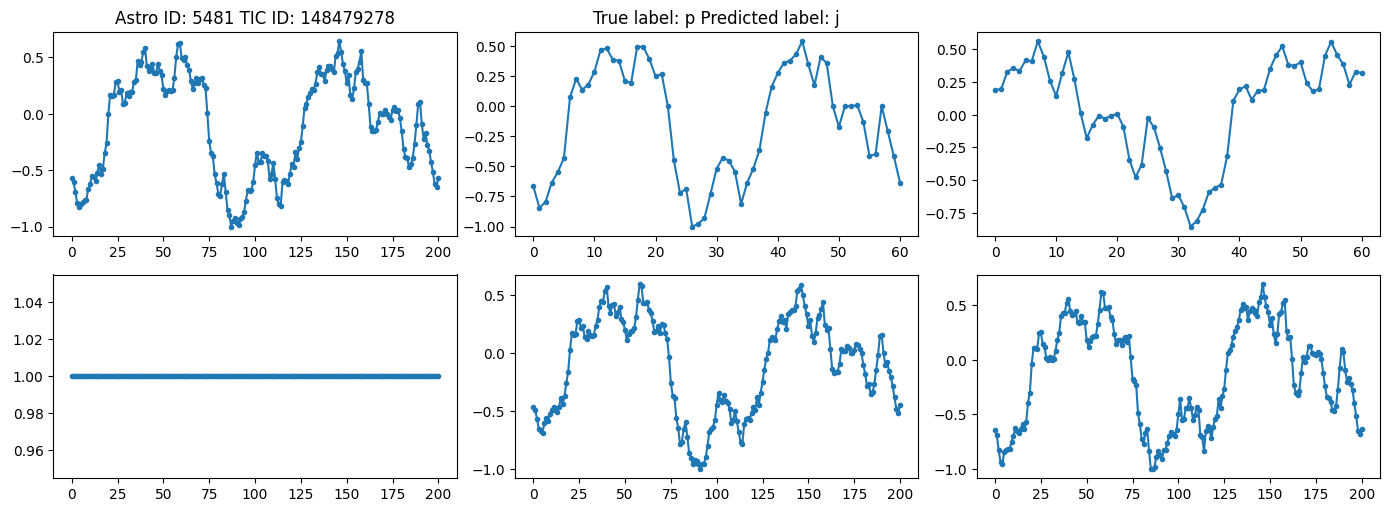

543 Astro ID: 4383 || TIC ID: 47601197 || True label: [ True False False False] || Max predicted prob: [0.7  0.71 0.01 0.  ]
disp_p_pred           0
disp_e_pred          10
disp_n_pred           0
disp_j_pred           0
maxcount             10
disp_p                1
disp_e                0
disp_n                0
disp_j                0
TIC ID         47601197
Name: 4383, dtype: int64
duration                 : [[-0.18403846]]
period                   : [[-0.2797015]]
tmag                     : [[0.899206]]
transit_depth            : [[0.30904767]]
n_folds                  : [[0.422549]]
star_mass                : [[0.2686577]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.55834943]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:47.024900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


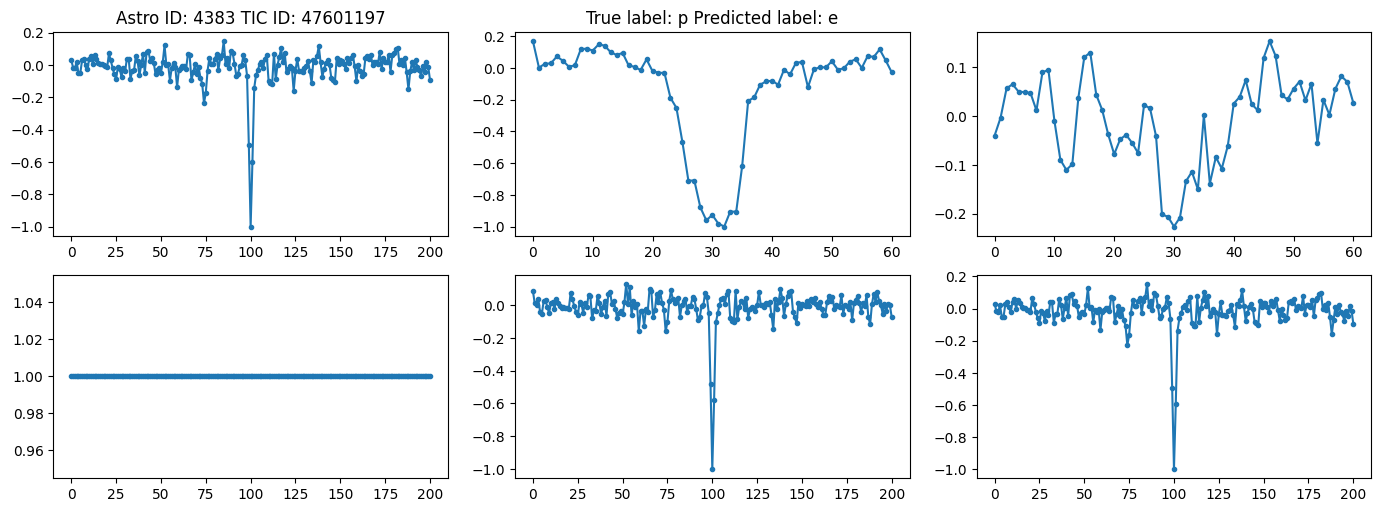

588 Astro ID: 6111 || TIC ID: 201604954 || True label: [ True False False False] || Max predicted prob: [0.01 0.02 0.   0.99]
disp_p_pred            0
disp_e_pred            0
disp_n_pred            0
disp_j_pred           10
maxcount              10
disp_p                 1
disp_e                 0
disp_n                 0
disp_j                 0
TIC ID         201604954
Name: 6111, dtype: int64
duration                 : [[-0.12744959]]
period                   : [[-0.42321628]]
tmag                     : [[1.7237233]]
transit_depth            : [[0.36417934]]
n_folds                  : [[0.58804566]]
star_mass                : [[0.30546355]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.5551649]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:48.052805: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


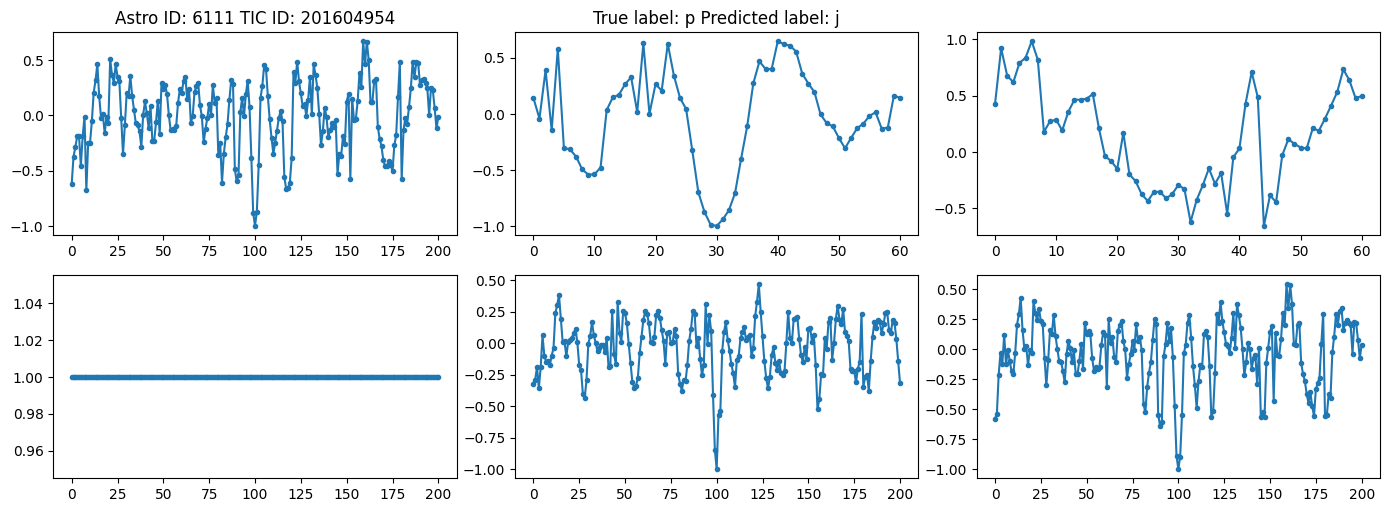

609 Astro ID: 3614 || TIC ID: 450559047 || True label: [False  True False False] || Max predicted prob: [0.27 0.38 0.04 0.75]
disp_p_pred            0
disp_e_pred            5
disp_n_pred            0
disp_j_pred            5
maxcount               5
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         450559047
Name: 3614, dtype: int64
duration                 : [[-0.21179217]]
period                   : [[-0.5355802]]
tmag                     : [[1.143133]]
transit_depth            : [[0.26948392]]
n_folds                  : [[0.8996703]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[0.10605135]]
star_rad_est             : [[-0.11407899]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:49.180814: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


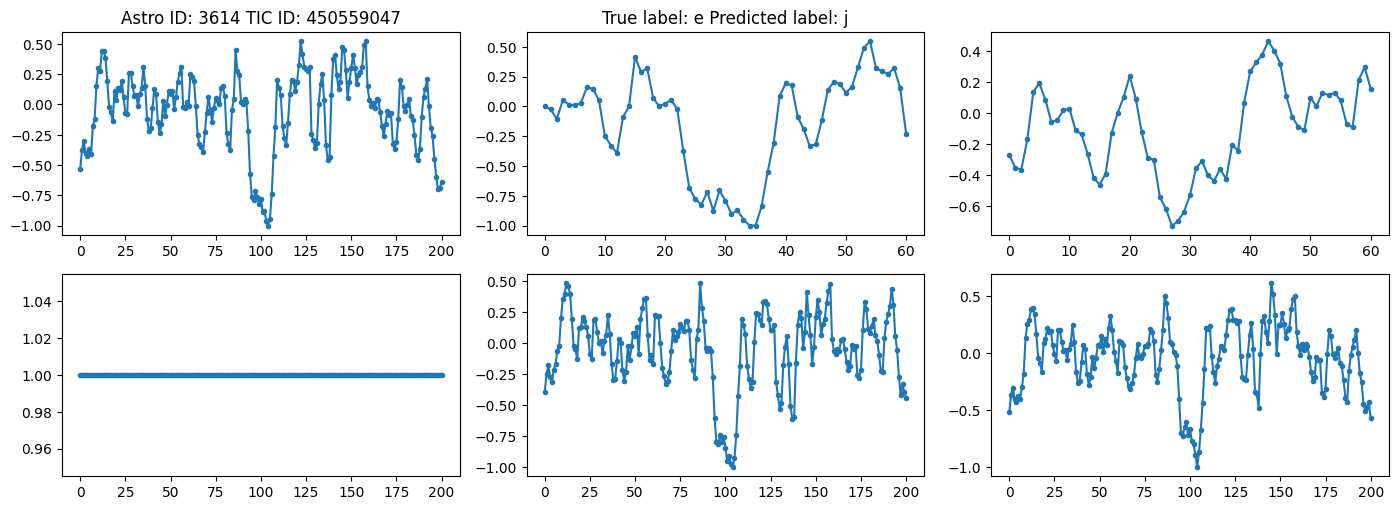

612 Astro ID: 2804 || TIC ID: 307314350 || True label: [False  True False False] || Max predicted prob: [0.98 0.04 0.   0.  ]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         307314350
Name: 2804, dtype: int64
duration                 : [[-0.09984329]]
period                   : [[-0.4644907]]
tmag                     : [[-0.555759]]
transit_depth            : [[0.39123654]]
n_folds                  : [[0.573064]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[-0.2422303]]
star_rad_est_present     : [[0.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:50.413413: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


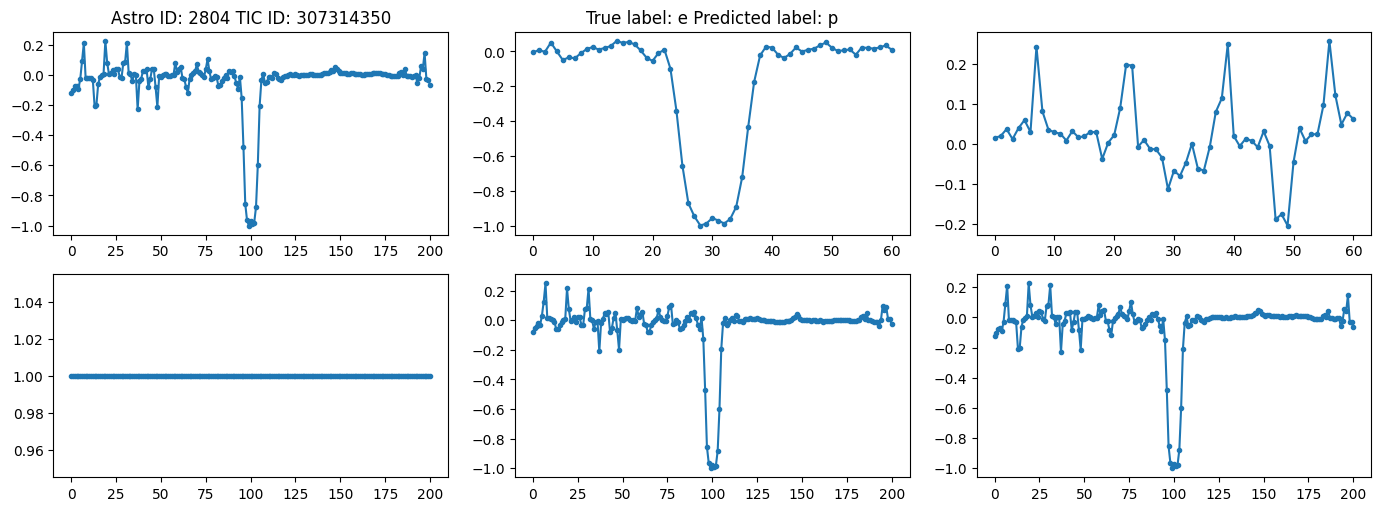

627 Astro ID: 3676 || TIC ID: 458856474 || True label: [False  True False False] || Max predicted prob: [0.16 0.54 0.05 0.68]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         458856474
Name: 3676, dtype: int64
duration                 : [[-0.03760583]]
period                   : [[-0.37071773]]
tmag                     : [[-2.2054794]]
transit_depth            : [[0.39566913]]
n_folds                  : [[0.6393768]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[0.22385103]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:51.508483: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


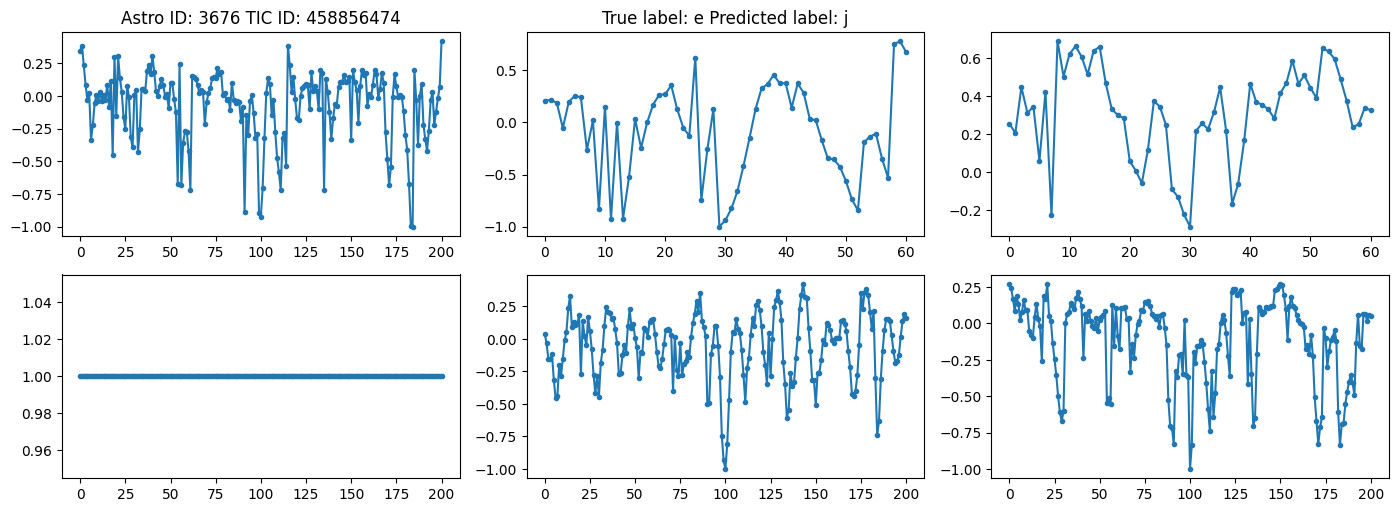

631 Astro ID: 3526 || TIC ID: 438976273 || True label: [False  True False False] || Max predicted prob: [0.91 0.46 0.01 0.  ]
disp_p_pred            2
disp_e_pred            8
disp_n_pred            0
disp_j_pred            0
maxcount               8
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         438976273
Name: 3526, dtype: int64
duration                 : [[-0.15813538]]
period                   : [[-0.23131199]]
tmag                     : [[0.06577638]]
transit_depth            : [[0.2815517]]
n_folds                  : [[0.422549]]
star_mass                : [[0.5262983]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.42368543]]
star_rad_est             : [[-0.19566804]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:52.938868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


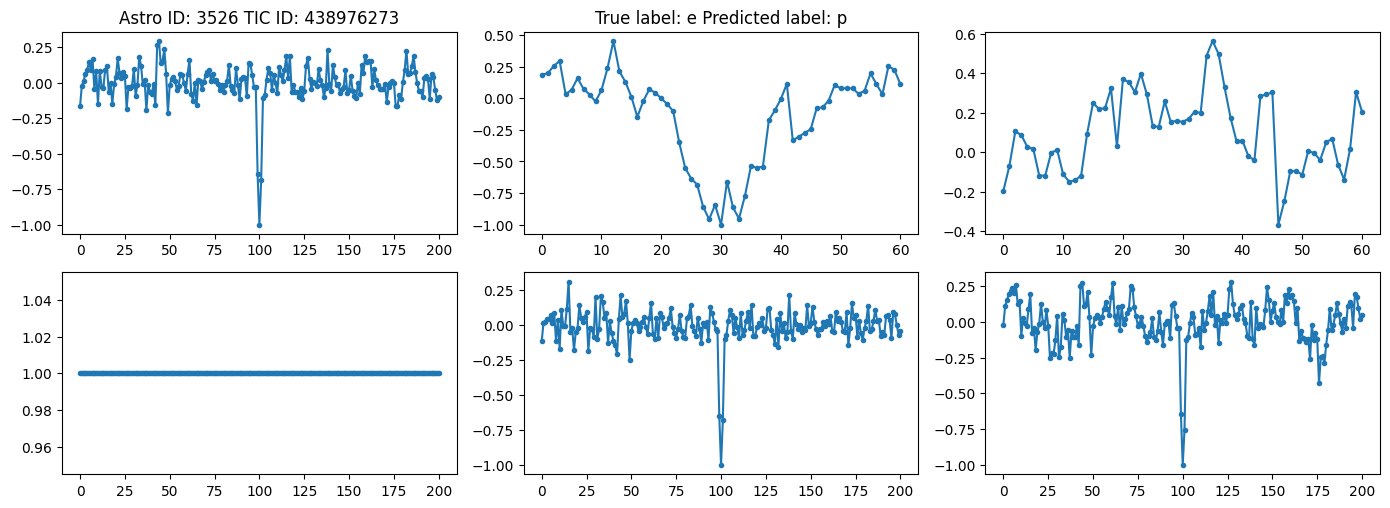

658 Astro ID: 1239 || TIC ID: 356235833 || True label: [False  True False False] || Max predicted prob: [0.85 0.54 0.01 0.  ]
disp_p_pred            2
disp_e_pred            8
disp_n_pred            0
disp_j_pred            0
maxcount               8
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         356235833
Name: 1239, dtype: int64
duration                 : [[-0.27237886]]
period                   : [[-0.54301804]]
tmag                     : [[-0.02814233]]
transit_depth            : [[0.2450572]]
n_folds                  : [[0.9460473]]
star_mass                : [[0.2686577]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.57080716]]
star_rad_est             : [[-0.22686659]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:54.038675: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


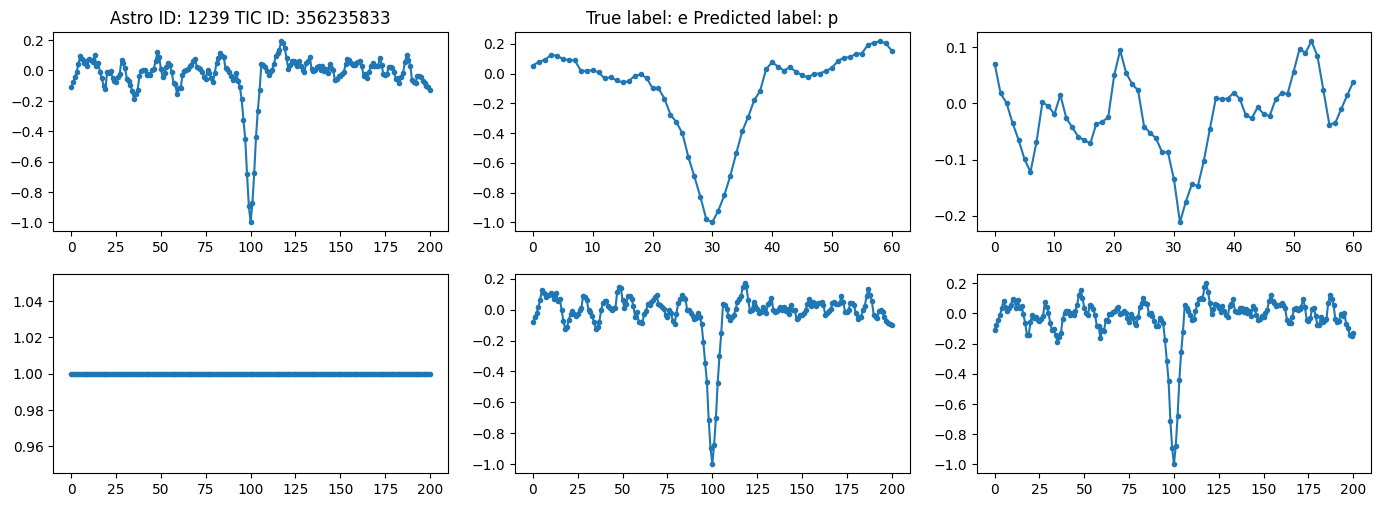

665 Astro ID: 2234 || TIC ID: 193140359 || True label: [ True  True False False] || Max predicted prob: [0.03 0.99 0.01 0.01]
disp_p_pred            0
disp_e_pred           10
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 1
disp_e                 2
disp_n                 0
disp_j                 0
TIC ID         193140359
Name: 2234, dtype: int64
duration                 : [[0.1162938]]
period                   : [[-0.01998382]]
tmag                     : [[-0.50297207]]
transit_depth            : [[0.35564673]]
n_folds                  : [[0.349485]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[-0.15895781]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:55.123994: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


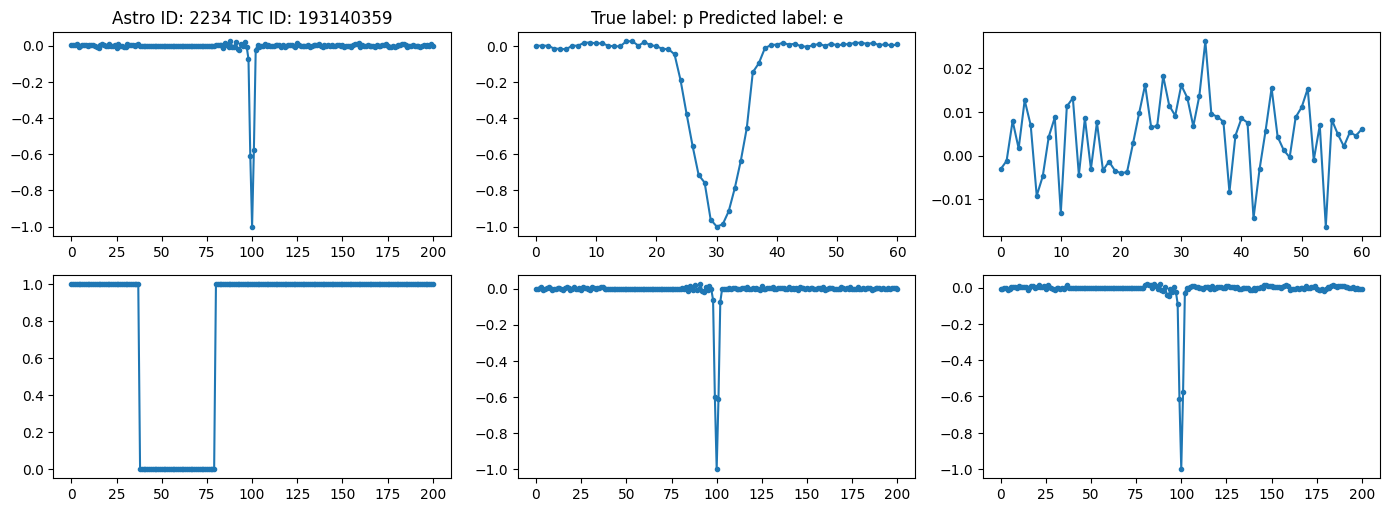

676 Astro ID: 3761 || TIC ID: 466055538 || True label: [False  True False False] || Max predicted prob: [0.74 0.49 0.03 0.07]
disp_p_pred            1
disp_e_pred            9
disp_n_pred            0
disp_j_pred            0
maxcount               9
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         466055538
Name: 3761, dtype: int64
duration                 : [[-0.18246862]]
period                   : [[-0.4835931]]
tmag                     : [[0.6808304]]
transit_depth            : [[0.2780124]]
n_folds                  : [[0.6152245]]
star_mass                : [[0.4036124]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.48113284]]
star_rad_est             : [[-0.21153486]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:56.354254: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


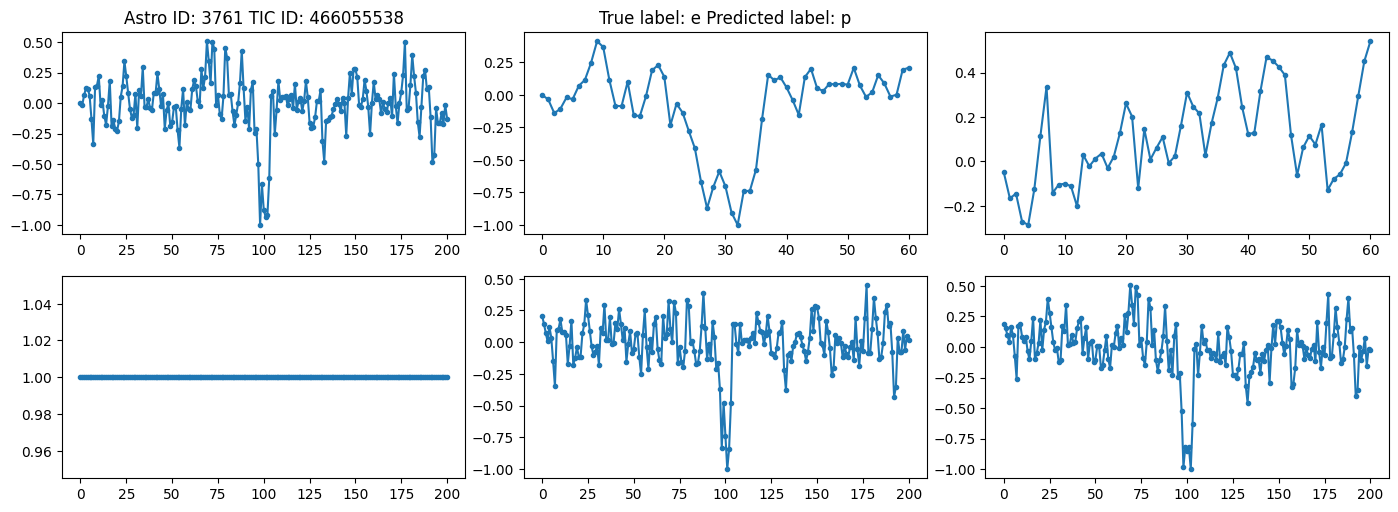

690 Astro ID: 2352 || TIC ID: 219852884 || True label: [False False  True False] || Max predicted prob: [0.95 0.23 0.03 0.05]
disp_p_pred            9
disp_e_pred            1
disp_n_pred            0
disp_j_pred            0
maxcount               9
disp_p                 0
disp_e                 0
disp_n                 1
disp_j                 0
TIC ID         219852884
Name: 2352, dtype: int64
duration                 : [[-0.18114798]]
period                   : [[-0.39133886]]
tmag                     : [[1.0252206]]
transit_depth            : [[0.24933407]]
n_folds                  : [[0.97224134]]
star_mass                : [[0.31773216]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.4552531]]
star_rad_est             : [[-0.20799279]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:57.470799: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


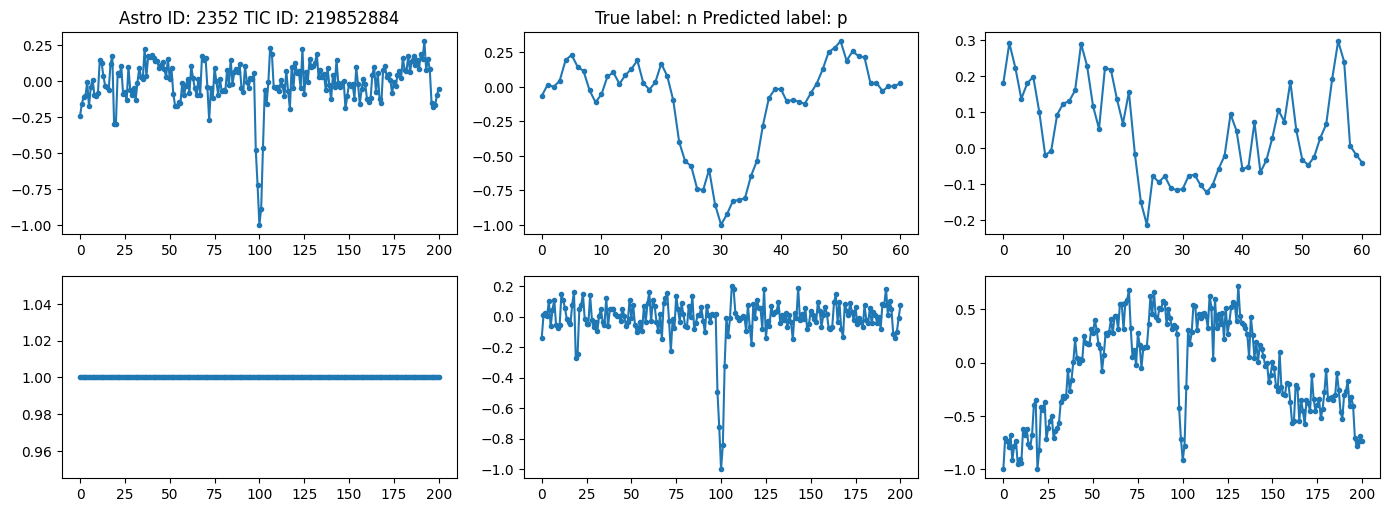

691 Astro ID: 2840 || TIC ID: 311700019 || True label: [False False False  True] || Max predicted prob: [0.61 0.34 0.04 0.6 ]
disp_p_pred            3
disp_e_pred            4
disp_n_pred            0
disp_j_pred            3
maxcount               4
disp_p                 0
disp_e                 0
disp_n                 0
disp_j                 1
TIC ID         311700019
Name: 2840, dtype: int64
duration                 : [[-0.20867002]]
period                   : [[-0.16939998]]
tmag                     : [[0.591336]]
transit_depth            : [[0.26511136]]
n_folds                  : [[0.38907564]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[0.14062276]]
star_rad_est             : [[-0.09571508]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:34:58.560990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


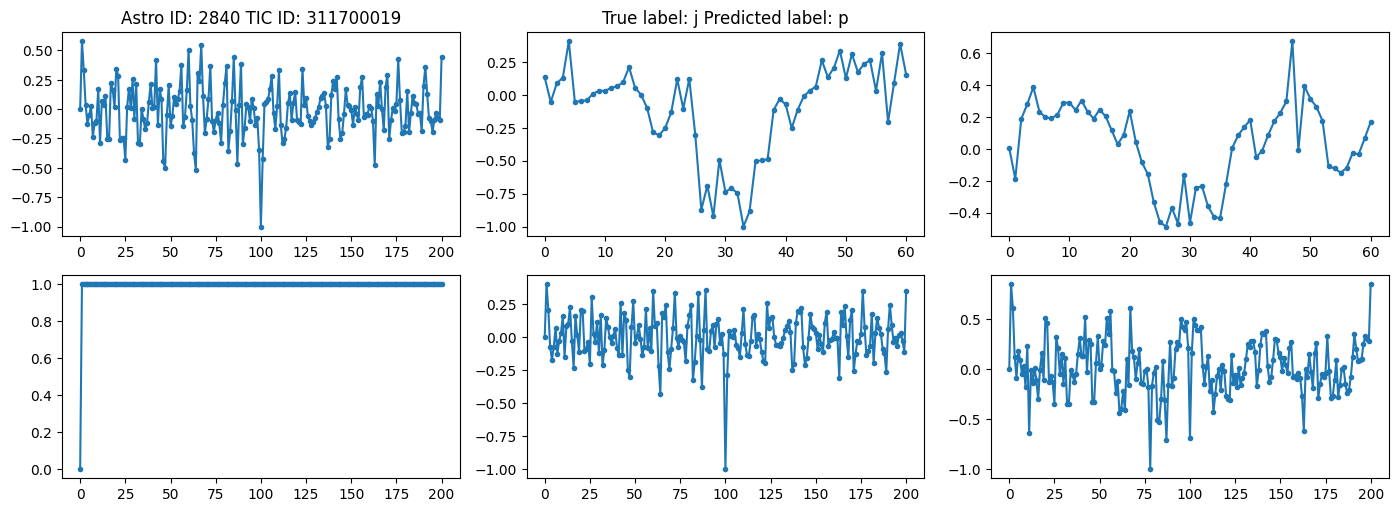

692 Astro ID: 4018 || TIC ID: 16102323 || True label: [False  True False False] || Max predicted prob: [0.82 0.71 0.01 0.  ]
disp_p_pred           1
disp_e_pred           9
disp_n_pred           0
disp_j_pred           0
maxcount              9
disp_p                0
disp_e                1
disp_n                0
disp_j                0
TIC ID         16102323
Name: 4018, dtype: int64
duration                 : [[-0.260492]]
period                   : [[-0.47363457]]
tmag                     : [[0.07780477]]
transit_depth            : [[0.34683707]]
n_folds                  : [[0.6152245]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[-0.16772829]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:34:59.704870: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


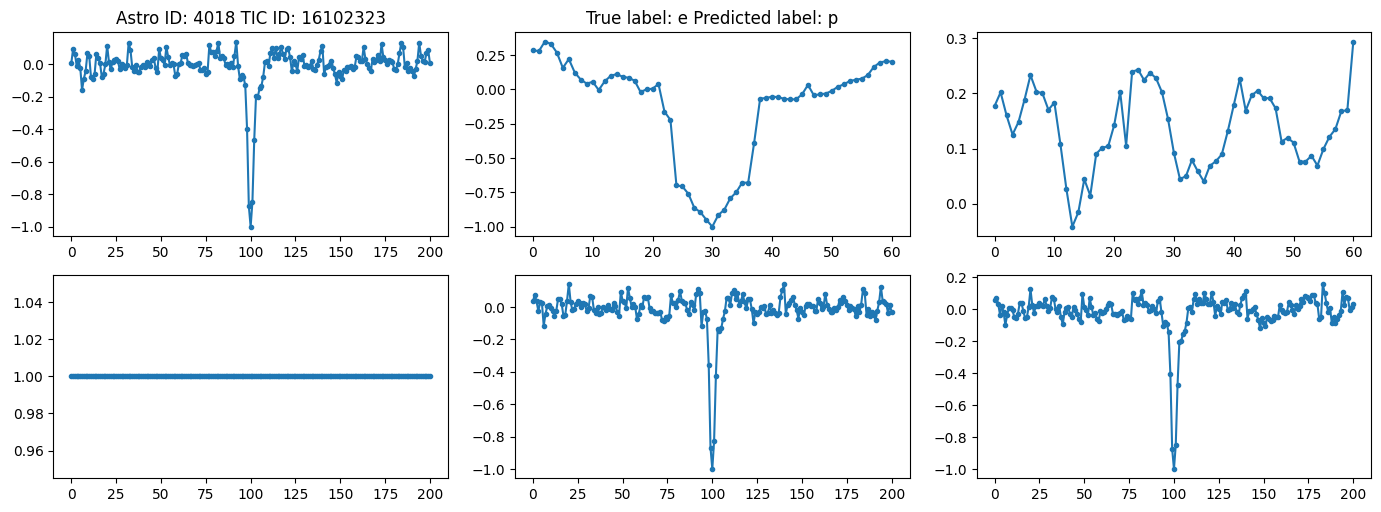

699 Astro ID: 2043 || TIC ID: 140938580 || True label: [False  True False False] || Max predicted prob: [0.99 0.02 0.   0.  ]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         140938580
Name: 2043, dtype: int64
duration                 : [[-0.21815684]]
period                   : [[-0.5034347]]
tmag                     : [[0.00638388]]
transit_depth            : [[0.22990774]]
n_folds                  : [[1.0021607]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[0.36927548]]
star_rad_est             : [[-0.05825301]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:35:01.184836: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


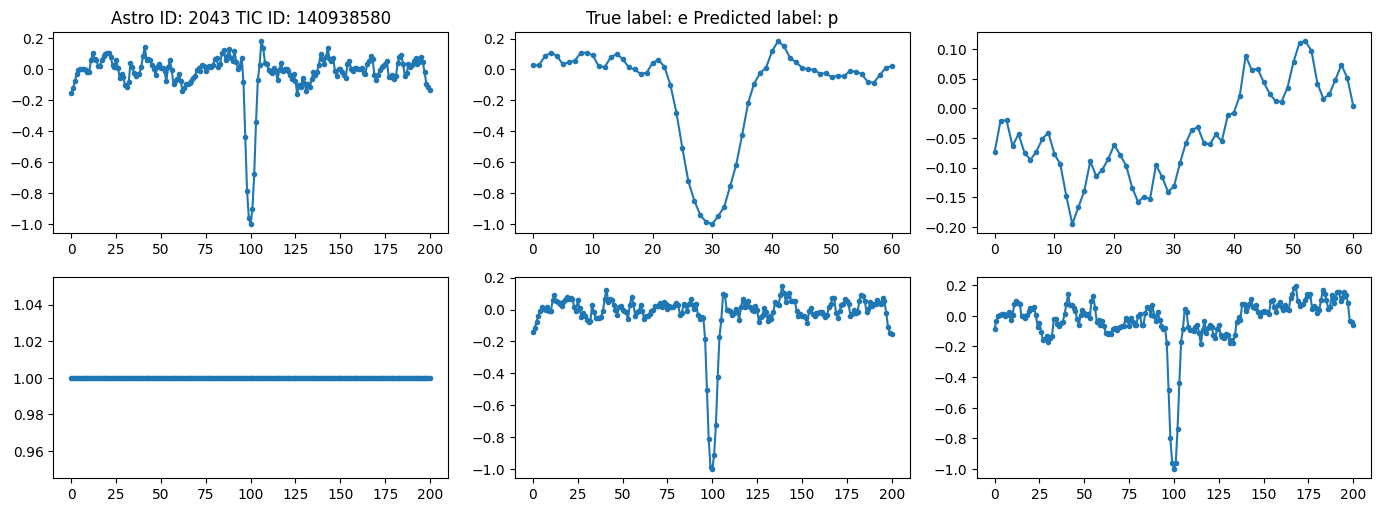

701 Astro ID: 752 || TIC ID: 261261490 || True label: [False  True False False] || Max predicted prob: [0.99 0.16 0.01 0.  ]
disp_p_pred           10
disp_e_pred            0
disp_n_pred            0
disp_j_pred            0
maxcount              10
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         261261490
Name: 752, dtype: int64
duration                 : [[-0.136288]]
period                   : [[-0.46187192]]
tmag                     : [[0.7290052]]
transit_depth            : [[0.27137497]]
n_folds                  : [[1.0021607]]
star_mass                : [[0.69805866]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.5278469]]
star_rad_est             : [[-0.21905954]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


2024-10-09 16:35:02.393366: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


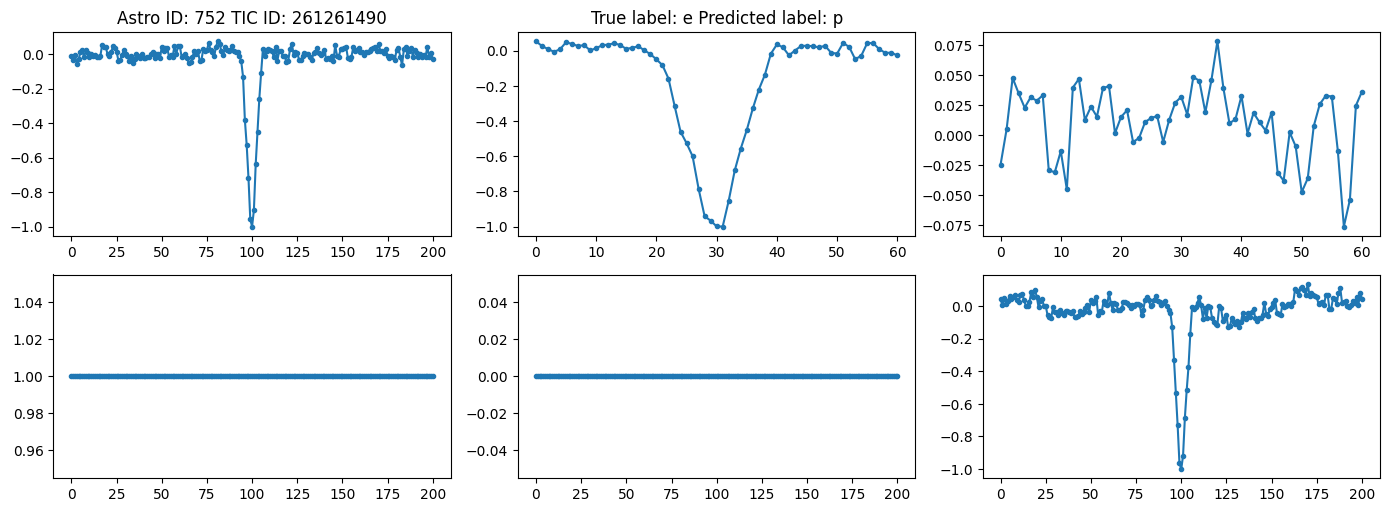

747 Astro ID: 809 || TIC ID: 271903247 || True label: [False  True False False] || Max predicted prob: [0.92 0.3  0.   0.  ]
disp_p_pred            7
disp_e_pred            3
disp_n_pred            0
disp_j_pred            0
maxcount               7
disp_p                 0
disp_e                 1
disp_n                 0
disp_j                 0
TIC ID         271903247
Name: 809, dtype: int64
duration                 : [[-0.18717404]]
period                   : [[-0.52361864]]
tmag                     : [[0.7357356]]
transit_depth            : [[0.32186285]]
n_folds                  : [[1.0021607]]
star_mass                : [[-0.9091278]]
star_mass_present        : [[0.]]
star_rad                 : [[-0.663398]]
star_rad_est             : [[1.8844227]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[0.]]


2024-10-09 16:35:03.542010: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


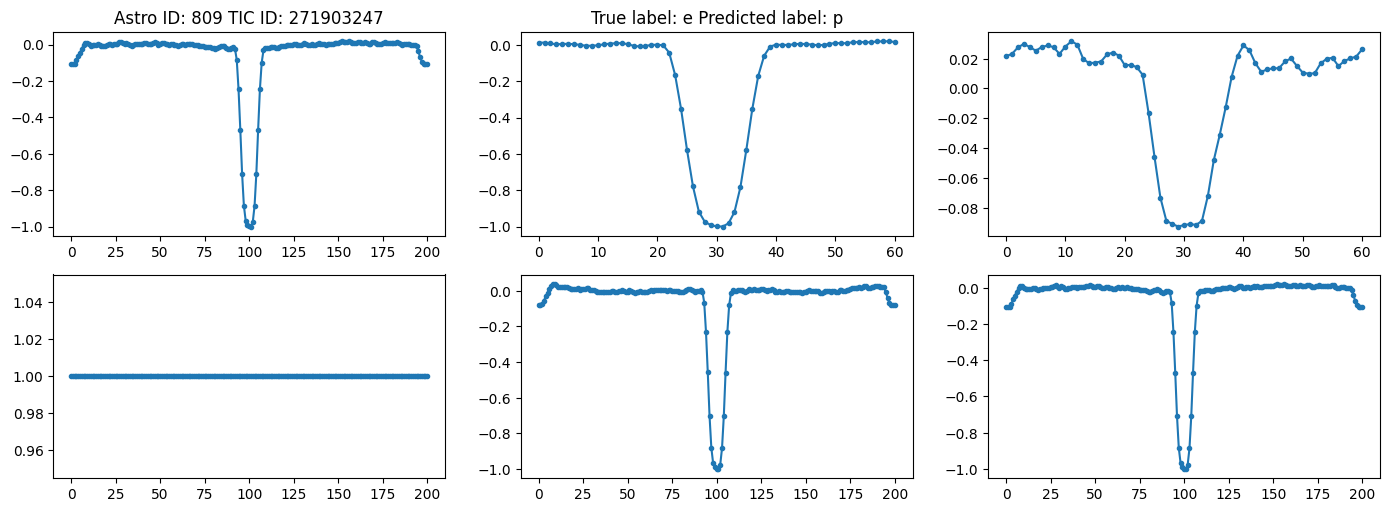

In [27]:
# Examine misclassifications
for i, astro_id in enumerate(astro_id_preds):
    if ytrue[i].argmax() != ypred[i].argmax():
        print(i, "Astro ID:", astro_id, "|| TIC ID:", tic_id_preds[i], "|| True label:", ytrue[i], "|| Max predicted prob:", ypred[i].round(2))
        print(pl.loc[astro_id])

        fig, axes = plot_ds_tce(ds, astro_id)
        axes[0, 0].set_title(f"Astro ID: {astro_id} TIC ID: {tic_id_preds[i]}")
        axes[0, 1].set_title(f"True label: {labels[ytrue[i].argmax()]} Predicted label: {labels[ypred[i].argmax()]}")
        plt.show()
        